## 1. Import Bibliotek

In [3]:
# Import bibliotek do obsługi danych
import pandas as pd
import numpy as np

# Import bibliotek do wizualizacji
import matplotlib.pyplot as plt
import seaborn as sns

# Import PyCaret do machine learning (regresja)
from pycaret.regression import *

# Import bibliotek do obsługi plików i środowiska
import os
import requests
import json
import pickle
from dotenv import load_dotenv
from datetime import datetime
import warnings

# Wyłączenie ostrzeżeń
warnings.filterwarnings('ignore')

# Ustawienia wyświetlania
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Ustawienie seed dla powtarzalności wyników
np.random.seed(42)

print("✓ Wszystkie biblioteki zostały zaimportowane pomyślnie")

✓ Wszystkie biblioteki zostały zaimportowane pomyślnie


## 2. Konfiguracja i Połączenie z Vercel Blob

In [4]:
# Załadowanie zmiennych środowiskowych z pliku .env
load_dotenv()

# Pobranie tokenu dostępu do Vercel Blob
BLOB_TOKEN = os.getenv('BLOB_READ_WRITE_TOKEN')

# Nazwa projektu na Vercel Blob
PROJECT_NAME = 'polmaraton-wroclaw-wyniki'

# Ścieżki do folderów projektu
DATA_DIR = 'data'
MODEL_DIR = 'model'
PLOTS_DIR = 'plots'

# Sprawdzenie czy token został załadowany
if BLOB_TOKEN:
    print("✓ Token Vercel Blob został załadowany")
else:
    print("✗ Błąd: Nie udało się załadować tokenu z pliku .env")

✓ Token Vercel Blob został załadowany


## 3. Pobranie Danych z Vercel Blob

In [5]:
# Funkcja do listowania plików w Vercel Blob
def list_vercel_blob_files():
    # Endpoint API Vercel Blob do listowania plików
    url = "https://blob.vercel-storage.com/"
    
    # Nagłówki z tokenem autoryzacji
    headers = {
        "authorization": f"Bearer {BLOB_TOKEN}"
    }
    
    try:
        # Wykonanie zapytania GET do API
        response = requests.get(url, headers=headers)
        
        # Sprawdzenie czy zapytanie się powiodło
        if response.status_code == 200:
            # Parsowanie odpowiedzi JSON
            data = response.json()
            # Zwrócenie listy plików
            return data.get('blobs', [])
        else:
            print(f"Błąd {response.status_code}: {response.text}")
            return []
    except Exception as e:
        print(f"Wystąpił błąd: {e}")
        return []

# Pobranie listy plików z Vercel Blob
files = list_vercel_blob_files()

# Wyświetlenie dostępnych plików
if files:
    print("Dostępne pliki w Vercel Blob:")
    for file in files:
        print(f"  - {file.get('pathname', 'N/A')}")
else:
    print("Brak plików lub błąd połączenia")

Dostępne pliki w Vercel Blob:
  - halfmarathon_wroclaw_2023__final.csv
  - halfmarathon_wroclaw_2024__final.csv


In [6]:
# Funkcja do pobrania pliku z Vercel Blob
def download_from_vercel_blob(filename):
    # Szukanie pliku w liście dostępnych plików
    file_info = next((f for f in files if filename in f.get('pathname', '')), None)
    
    if file_info:
        # Pobranie URL pliku
        file_url = file_info.get('url')
        
        # Pobranie zawartości pliku
        response = requests.get(file_url)
        
        # Sprawdzenie czy pobranie się powiodło
        if response.status_code == 200:
            # Ścieżka do zapisu lokalnego
            local_path = os.path.join(DATA_DIR, filename)
            
            # Zapis pliku lokalnie
            with open(local_path, 'wb') as f:
                f.write(response.content)
            
            print(f"✓ Plik '{filename}' został pobrany i zapisany w: {local_path}")
            return local_path
        else:
            print(f"✗ Błąd pobierania pliku: {response.status_code}")
            return None
    else:
        print(f"✗ Nie znaleziono pliku '{filename}' w Vercel Blob")
        return None

# Znajdź wszystkie pliki CSV z danymi
csv_files = []
for file in files:
    pathname = file.get('pathname', '')
    # Szukaj plików CSV lub plików z "wyniki" w nazwie
    if pathname.endswith('.csv') or 'wyniki' in pathname.lower():
        filename = pathname.split('/')[-1]  # Weź samą nazwę pliku
        csv_files.append(filename)

print(f"Znaleziono {len(csv_files)} plik(ów) CSV:")
for f in csv_files:
    print(f"  - {f}")

# Pobranie wszystkich znalezionych plików CSV
data_paths = []
if csv_files:
    print("\nPobieranie plików...")
    for csv_file in csv_files:
        path = download_from_vercel_blob(csv_file)
        if path:
            data_paths.append(path)
    print(f"\n✓ Pobrano {len(data_paths)} plik(ów)")
else:
    print("Nie znaleziono plików CSV z danymi. Sprawdź dostępne pliki powyżej.")
    data_paths = []

Znaleziono 2 plik(ów) CSV:
  - halfmarathon_wroclaw_2023__final.csv
  - halfmarathon_wroclaw_2024__final.csv

Pobieranie plików...
✓ Plik 'halfmarathon_wroclaw_2023__final.csv' został pobrany i zapisany w: data\halfmarathon_wroclaw_2023__final.csv
✓ Plik 'halfmarathon_wroclaw_2024__final.csv' został pobrany i zapisany w: data\halfmarathon_wroclaw_2024__final.csv

✓ Pobrano 2 plik(ów)


## 4. Wczytanie Danych do DataFrame

In [7]:
# Wczytanie i połączenie danych z wszystkich plików CSV
if data_paths:
    dataframes = []  # Lista do przechowywania DataFrames
    
    print("Wczytywanie plików CSV...")
    for path in data_paths:
        if os.path.exists(path):
            # Wczytanie pojedynczego pliku
            # Parametr sep=';' bo dane są rozdzielone średnikami
            temp_df = pd.read_csv(path, sep=';')
            
            # Wyciągnięcie roku z nazwy pliku (np. "wyniki_2023.csv" -> 2023)
            filename = os.path.basename(path)
            # Szukaj 4-cyfrowego roku w nazwie pliku
            import re
            year_match = re.search(r'20\d{2}', filename)
            if year_match:
                year = int(year_match.group())
                # Dodaj kolumnę 'rok' do DataFrame
                temp_df['rok'] = year
                print(f"  ✓ Wczytano: {filename} - {len(temp_df)} wierszy, {len(temp_df.columns)} kolumn (rok: {year})")
            else:
                print(f"  ✓ Wczytano: {filename} - {len(temp_df)} wierszy, {len(temp_df.columns)} kolumn (brak roku w nazwie)")
            
            dataframes.append(temp_df)
    
    # Połączenie wszystkich DataFrames w jeden
    if dataframes:
        df = pd.concat(dataframes, ignore_index=True)
        print(f"\n✓ Wszystkie dane zostały połączone pomyślnie")
        print(f"Łączna liczba wierszy: {len(df)}")
        print(f"Liczba kolumn: {len(df.columns)}")
        
        # Sprawdź czy są duplikaty po połączeniu
        # Dzięki kolumnie 'rok', duplikaty będą usuwane tylko jeśli ROK + wszystkie dane są identyczne
        # To znaczy, że ta sama osoba w różnych latach NIE będzie uznana za duplikat
        initial_rows = len(df)
        df = df.drop_duplicates()
        removed_duplicates = initial_rows - len(df)
        if removed_duplicates > 0:
            print(f"Usunięto {removed_duplicates} duplikatów (identyczne wiersze w tym samym roku)")
        else:
            print("Brak duplikatów do usunięcia")
    else:
        print("✗ Nie udało się wczytać żadnych danych")
        df = None
else:
    print("✗ Nie można wczytać danych. Brak pobranych plików.")
    df = None

Wczytywanie plików CSV...
  ✓ Wczytano: halfmarathon_wroclaw_2023__final.csv - 8950 wierszy, 28 kolumn (rok: 2023)
  ✓ Wczytano: halfmarathon_wroclaw_2024__final.csv - 13007 wierszy, 28 kolumn (rok: 2024)

✓ Wszystkie dane zostały połączone pomyślnie
Łączna liczba wierszy: 21957
Liczba kolumn: 28
Brak duplikatów do usunięcia


## 5. Eksploracja Danych (EDA) - Podstawowe Informacje

### 🔍 Czym jest EDA (Exploratory Data Analysis)?

**EDA to "rozmowa" z danymi** - zanim zbudujemy model, musimy poznać nasze dane!

**Po co to robimy?**
- 📊 Zrozumienie struktury danych (ile wierszy, kolumn, jakie typy)
- 🔎 Wykrycie problemów (braki, błędy, duplikaty)
- 📈 Znalezienie wzorców i zależności
- 💡 Podejmowanie decyzji o czyszczeniu danych

**Proces EDA:**
1. **Podglądamy** pierwsze wiersze - jak wyglądają dane?
2. **Sprawdzamy typy** - liczby czy tekst?
3. **Statystyki** - średnie, minimum, maksimum
4. **Braki** - gdzie brakuje danych?
5. **Wizualizacje** - wykresy pokazują więcej niż liczby!

**Pamiętaj:** EDA to detektywistyczna praca - szukamy wskazówek!

In [8]:
# Wyświetlenie pierwszych 10 wierszy danych
print("Pierwsze 10 wierszy danych:")
display(df.head(10))

Pierwsze 10 wierszy danych:


,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,Rocznik,5 km Czas,5 km Miejsce Open,5 km Tempo,10 km Czas,10 km Miejsce Open,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,rok
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,1.0,1992.0,00:14:37,1.0,2.923333,00:29:15,1.0,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509,2023
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,2.0,1986.0,00:14:48,2.0,2.960000,00:29:43,2.0,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875,2023
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,1.0,1996.0,00:15:46,4.0,3.153333,00:31:23,3.0,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475,2023
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,3.0,1988.0,00:16:11,6.0,3.236667,00:32:10,5.0,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963,2023
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,2.0,1995.0,00:16:12,7.0,3.240000,00:32:35,7.0,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654,2023
5,6.0,2551,ADAM,PUTYRA,WROCŁAW,POL,NaN,M,6.0,M40,1.0,1983.0,00:16:09,5.0,3.230000,00:32:30,6.0,3.270000,00:49:31,6.0,3.403333,01:07:28,6.0,3.590000,0.024267,01:10:34,3.345184,2023
6,7.0,1288,MICHAŁ,WÓJCIK,KROŚNICE,POL,WOSIEK TEAM KS AZS AWF WROCŁAW,M,7.0,M20,3.0,1999.0,00:15:37,3.0,3.123333,00:31:25,4.0,3.160000,00:48:18,4.0,3.376667,01:07:38,7.0,3.866667,0.048933,01:11:18,3.379948,2023
7,8.0,7837,PATRYK,CHRZANOWSKI,BIELAWA,POL,PCH SPORT COMPLEX,M,8.0,M30,4.0,1989.0,00:16:30,8.0,3.300000,00:32:55,8.0,3.283333,00:49:57,8.0,3.406667,01:08:18,8.0,3.670000,0.024667,01:11:42,3.398910,2023
8,9.0,5657,CYPRIAN,GRZELKA,POGRZEBIEŃ,POL,GKS PIAST GLIWICE,M,9.0,M20,4.0,2001.0,00:17:10,14.0,3.433333,00:34:23,16.0,3.443333,00:52:11,12.0,3.560000,01:11:03,10.0,3.773333,0.022733,01:14:16,3.520581,2023
9,10.0,5927,ADAM,KONIECZNY,ZANIEMYSL,POL,NaN,M,10.0,M30,5.0,1992.0,00:16:53,11.0,3.376667,00:33:55,11.0,3.406667,00:51:39,10.0,3.546667,01:10:50,9.0,3.836667,0.030400,01:14:22,3.525322,2023


### 👀 Podgląd Danych

**Co sprawdzamy:**
- Czy dane wczytały się poprawnie?
- Jak wyglądają pierwsze wiersze?
- Czy widzimy coś podejrzanego?

**Zwróć uwagę na:**
- Format czasu (H:MM:SS)
- Brakujące wartości (NaN)
- Dziwne wartości (np. ujemne czasy)

In [9]:
# Wyświetlenie informacji o strukturze danych
print("Informacje o strukturze danych:")
print(df.info())

Informacje o strukturze danych:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21957 entries, 0 to 21956
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Miejsce                    18450 non-null  float64
 1   Numer startowy             21957 non-null  int64  
 2   Imię                       21957 non-null  object 
 3   Nazwisko                   21957 non-null  object 
 4   Miasto                     17774 non-null  object 
 5   Kraj                       18450 non-null  object 
 6   Drużyna                    8402 non-null   object 
 7   Płeć                       21946 non-null  object 
 8   Płeć Miejsce               18450 non-null  float64
 9   Kategoria wiekowa          21926 non-null  object 
 10  Kategoria wiekowa Miejsce  18430 non-null  float64
 11  Rocznik                    21472 non-null  float64
 12  5 km Czas                  18411 non-null  object 
 13  5 km Miejsce O

### 📋 Informacje o Strukturze

**Sprawdzamy:**
- Liczbę wierszy (każdy wiersz = jeden zawodnik)
- Liczbę kolumn (każda kolumna = jedna cecha)
- Typy danych (int, float, object/string)
- Ilość pamięci zajmowanej przez dane

**Typy danych:**
- `int64/float64` = liczby (wiek, czasy w sekundach, miejsca)
- `object` = tekst (imiona, miasta, czasy w formacie tekstowym)

In [10]:
# Wyświetlenie nazw wszystkich kolumn
print("Nazwy kolumn w datasecie:")
for idx, col in enumerate(df.columns, 1):
    print(f"{idx}. {col}")

Nazwy kolumn w datasecie:
1. Miejsce
2. Numer startowy
3. Imię
4. Nazwisko
5. Miasto
6. Kraj
7. Drużyna
8. Płeć
9. Płeć Miejsce
10. Kategoria wiekowa
11. Kategoria wiekowa Miejsce
12. Rocznik
13. 5 km Czas
14. 5 km Miejsce Open
15. 5 km Tempo
16. 10 km Czas
17. 10 km Miejsce Open
18. 10 km Tempo
19. 15 km Czas
20. 15 km Miejsce Open
21. 15 km Tempo
22. 20 km Czas
23. 20 km Miejsce Open
24. 20 km Tempo
25. Tempo Stabilność
26. Czas
27. Tempo
28. rok


In [11]:
# Statystyki opisowe dla zmiennych numerycznych
print("Statystyki opisowe dla zmiennych numerycznych:")
display(df.describe())

Statystyki opisowe dla zmiennych numerycznych:


,Miejsce,Numer startowy,Płeć Miejsce,Kategoria wiekowa Miejsce,Rocznik,5 km Miejsce Open,5 km Tempo,10 km Miejsce Open,10 km Tempo,15 km Miejsce Open,15 km Tempo,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Tempo,rok
count,18450.000000,21957.000000,18450.000000,18430.000000,21472.000000,18411.000000,18411.000000,18427.000000,18395.000000,18428.000000,18413.000000,18439.000000,18422.000000,18377.000000,18450.000000,21957.000000
mean,4675.680325,9131.001685,2741.137615,734.757352,1981.449935,4684.677638,5.586340,4681.817984,5.572067,4677.332103,5.900787,4676.539997,6.342749,0.052152,5.852857,2023.592385
std,2768.846110,14449.830643,1913.875736,590.148277,76.047837,2776.085712,0.825451,2772.998560,0.898941,2768.849902,1.012626,2769.430762,1.222979,0.047737,0.961692,0.491402
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.920000,1.000000,3.083333,1.000000,3.086667,-0.345333,3.036265,2023.000000
25%,2307.000000,2994.000000,1154.000000,251.000000,1978.000000,2311.500000,5.016667,2309.000000,4.940000,2309.000000,5.193333,2308.000000,5.490000,0.020533,5.178952,2023.000000
50%,4613.000000,5847.000000,2307.000000,589.000000,1985.000000,4619.000000,5.543333,4617.000000,5.486667,4613.500000,5.766667,4614.000000,6.140000,0.041867,5.732796,2024.000000
75%,6919.000000,8771.000000,4227.750000,1071.750000,1992.000000,6927.000000,6.125000,6927.000000,6.110000,6920.250000,6.503333,6919.500000,7.020000,0.073333,6.442087,2024.000000
max,10302.000000,86990.000000,7240.000000,2388.000000,2006.000000,10353.000000,12.750000,10330.000000,11.346667,10305.000000,11.213333,10306.000000,14.940000,0.629533,10.076637,2024.000000


### 📊 Statystyki Opisowe - Zmienne Numeryczne

**Co oznaczają te liczby:**
- **count** - ile wartości (nie-pustych)
- **mean** - średnia wartość
- **std** - odchylenie standardowe (jak bardzo dane są rozproszone)
- **min/max** - najmniejsza i największa wartość
- **25%, 50%, 75%** - kwartyle (podział na 4 części)

**Co szukamy:**
- Czy zakresy wartości mają sens? (np. rocznik 1950-2010)
- Czy są ekstremalne wartości? (outliers)
- Jak duże jest odchylenie standardowe? (duże = dane bardzo zróżnicowane)

In [12]:
# Statystyki opisowe dla zmiennych kategorycznych
print("Statystyki opisowe dla zmiennych kategorycznych:")
display(df.describe(include=['object']))

Statystyki opisowe dla zmiennych kategorycznych:


,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Kategoria wiekowa,5 km Czas,10 km Czas,15 km Czas,20 km Czas,Czas
count,21957,21957,17774,18450,8402,21946,21926,18411,18427,18428,18439,19902
unique,975,10274,2170,43,4035,2,13,1331,2497,3650,4825,5042
top,TOMASZ,ZAWODNIK,WROCŁAW,POL,BRAK,M,M40,00:26:04,00:55:28,01:23:09,01:53:16,DNS
freq,795,699,5997,18038,161,15339,5157,53,29,19,19,1332


### 📝 Statystyki Opisowe - Zmienne Kategoryczne (Tekstowe)

**Co oznaczają te liczby:**
- **count** - ile wartości (nie-pustych)
- **unique** - ile unikalnych wartości (np. ile różnych miast)
- **top** - najczęstsza wartość
- **freq** - ile razy występuje najczęstsza wartość

In [13]:
# Sprawdzenie brakujących wartości
print("Analiza brakujących wartości:")
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Kolumna': missing.index,
    'Brakujące wartości': missing.values,
    'Procent': missing_percent.values
})
# Wyświetlenie tylko kolumn z brakującymi wartościami
missing_df = missing_df[missing_df['Brakujące wartości'] > 0].sort_values('Brakujące wartości', ascending=False)
display(missing_df)

Analiza brakujących wartości:


,Kolumna,Brakujące wartości,Procent
6,Drużyna,13555,61.734299
4,Miasto,4183,19.050872
24,Tempo Stabilność,3580,16.304595
17,10 km Tempo,3562,16.222617
12,5 km Czas,3546,16.149747
13,5 km Miejsce Open,3546,16.149747
14,5 km Tempo,3546,16.149747
20,15 km Tempo,3544,16.140639
23,20 km Tempo,3535,16.099649
15,10 km Czas,3530,16.076878


### 🕳️ Brakujące Wartości - Analiza

**Dlaczego to ważne:**
- Modele ML nie lubią pustych wartości (NaN)
- Musimy zdecydować co z nimi zrobić

**Strategie:**
1. **Usunąć wiersze** - jeśli brakuje target (Czas)
2. **Usunąć kolumny** - jeśli braki > 50% (np. Drużyna)
3. **Wypełnić** - średnią, medianą, najczęstszą wartością
4. **Zostawić** - PyCaret może automatycznie wypełnić

**Wskazówka:** Jeśli kolumna ma >60% braków i nie jest ważna - lepiej usunąć!

In [14]:
# Analiza duplikatów
duplicates = df.duplicated().sum()
print(f"Liczba duplikatów w datasecie: {duplicates}")

Liczba duplikatów w datasecie: 0


## 6. Wizualizacje - Rozkład Zmiennych

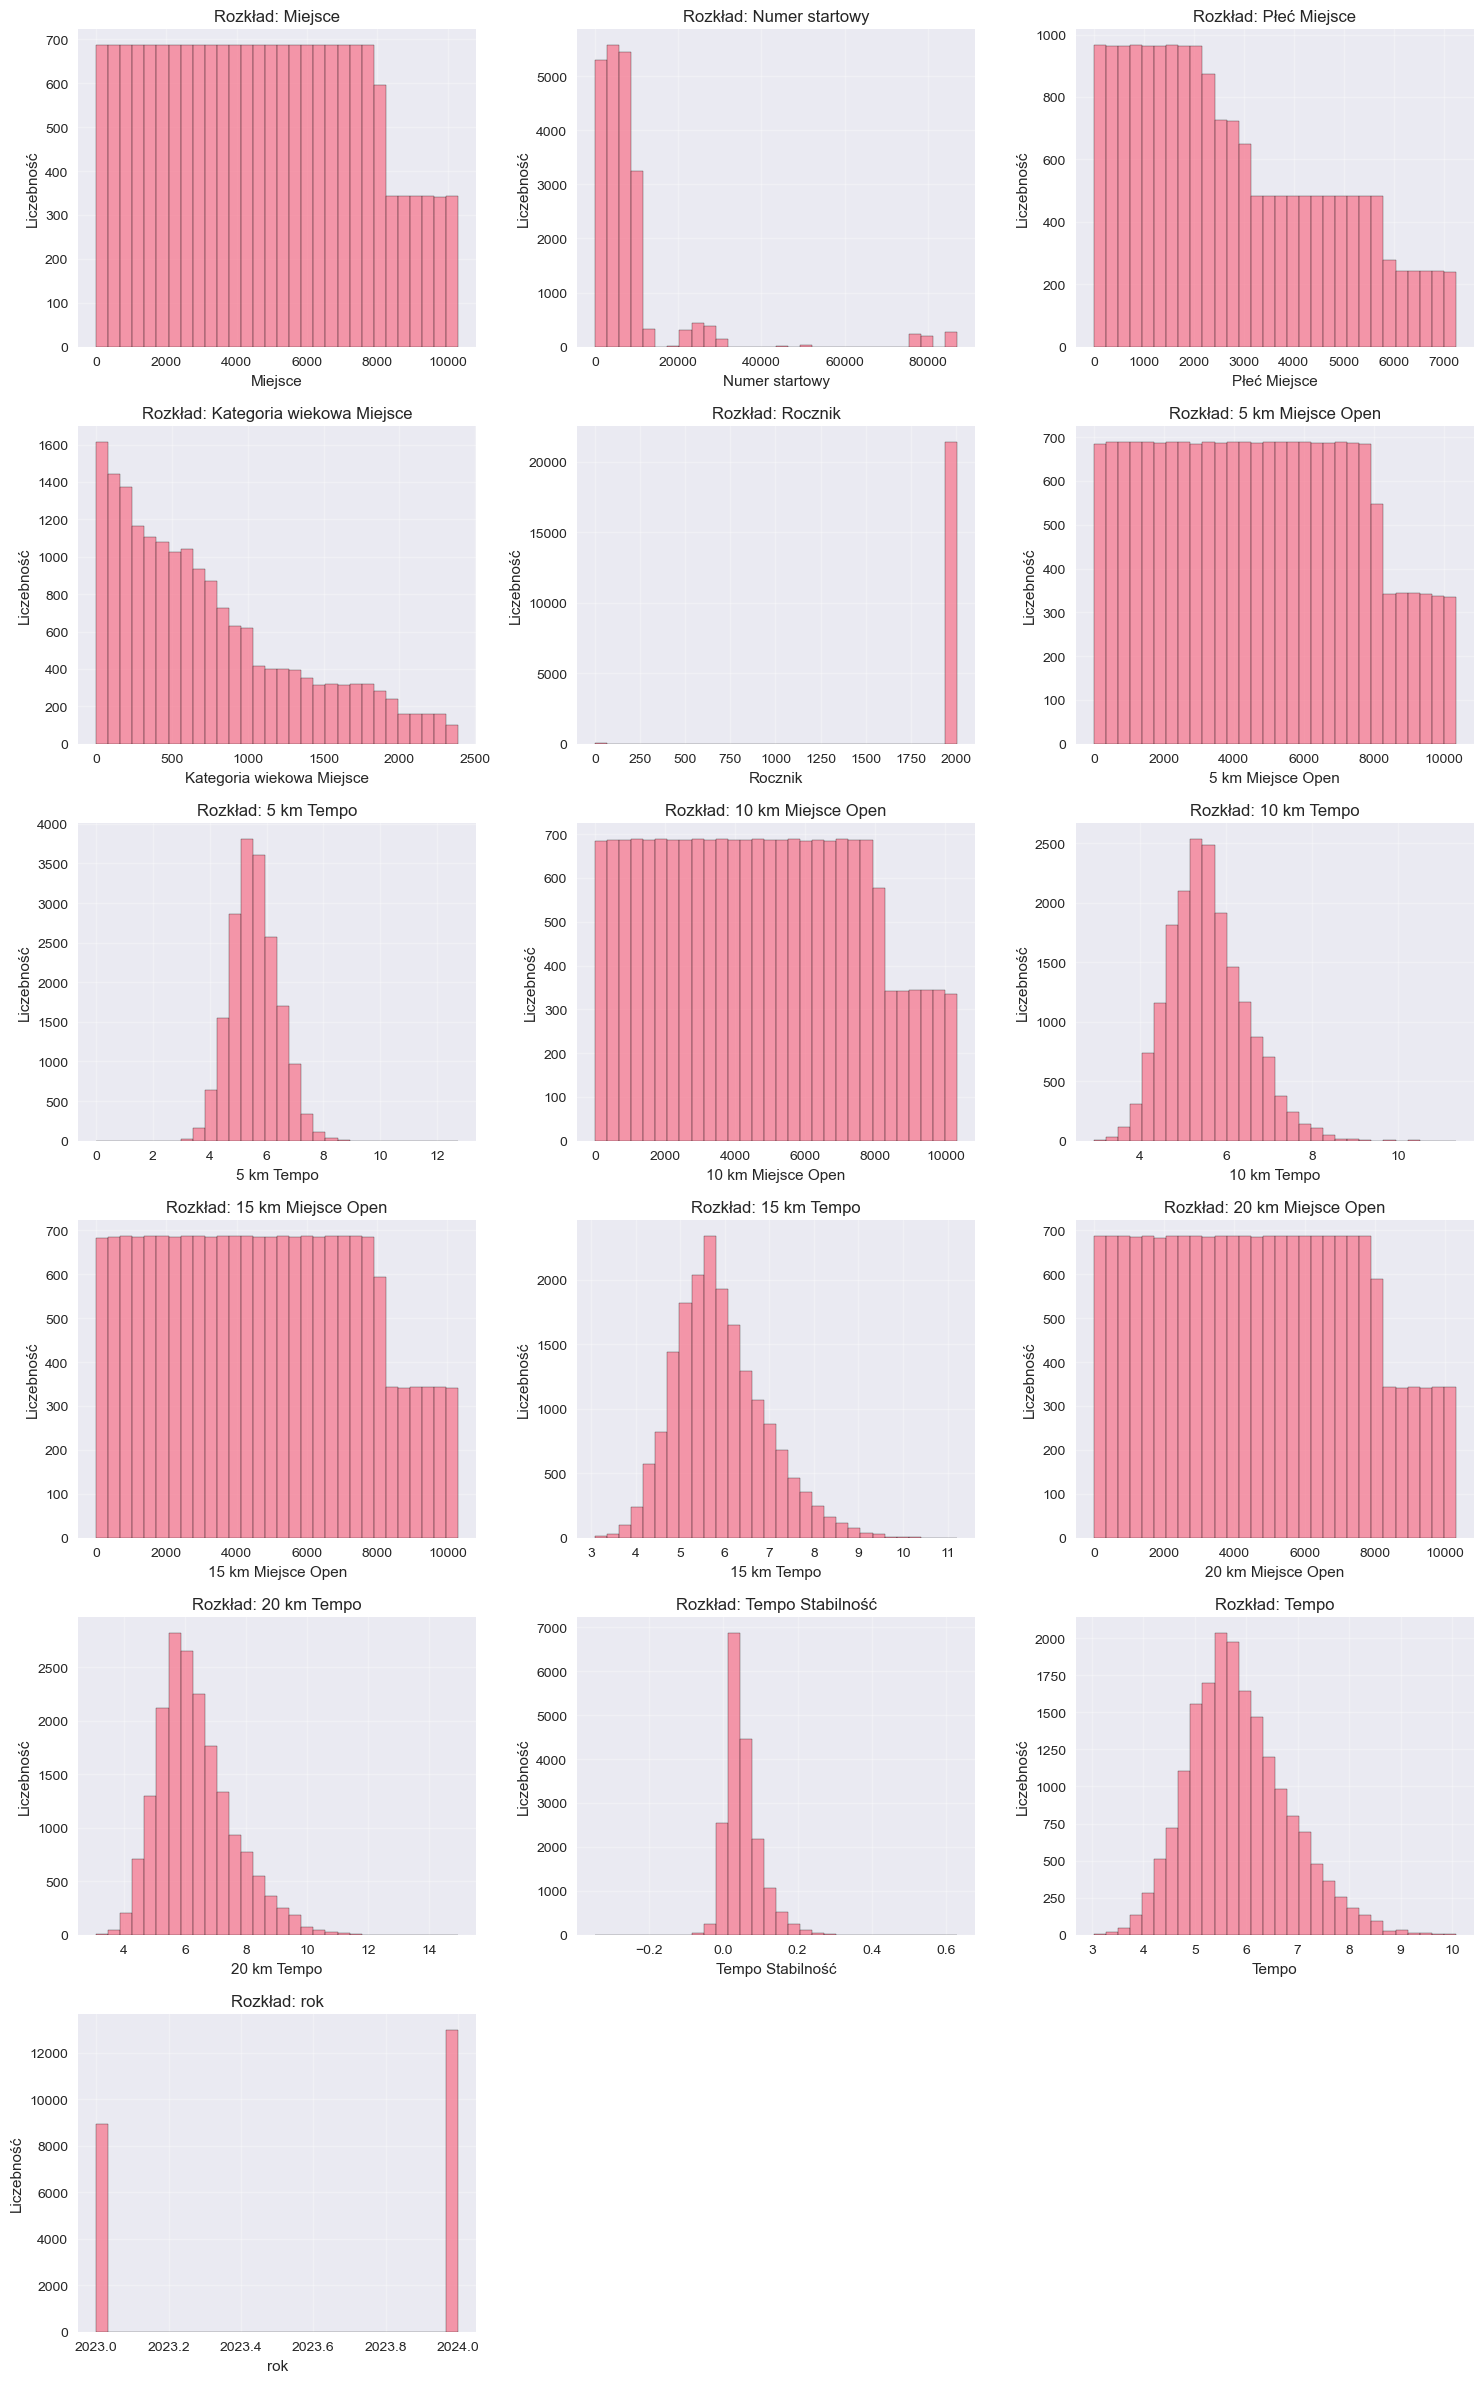

✓ Wykres zapisany w: plots\numeric_distributions.png


In [15]:
# Wykres rozkładów dla zmiennych numerycznych
# Wybierz kolumny numeryczne
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Stwórz subploty dla każdej zmiennej numerycznej
n_cols = 3  # Liczba kolumn w siatce
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # Oblicz liczbę wierszy

# Stwórz figurę
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

# Dla każdej zmiennej numerycznej narysuj histogram
for idx, col in enumerate(numeric_cols):
    # Histogram z krzywą gęstości
    axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Rozkład: {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Liczebność')
    axes[idx].grid(True, alpha=0.3)

# Ukryj niewykorzystane subploty
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].set_visible(False)

# Dopasuj layout
plt.tight_layout()
# Zapisz wykres
plt.savefig(os.path.join(PLOTS_DIR, 'numeric_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Wykres zapisany w: {os.path.join(PLOTS_DIR, 'numeric_distributions.png')}")

### 💡 Wnioski z histogramów:

**Spodziewane obserwacje:**
- **Miejsca** - równomierny rozkład (wszyscy zajęli jakieś miejsce 1-21957)
- **Rocznik** - najwięcej zawodników urodzonych ~1985-1995 (30-40 lat)
- **Tempo** - większość zawodników w podobnym tempie, kilka outliers
- **Czasy na punktach** - rozkłady prawdopodobnie skośne w prawo (kilku bardzo szybkich, więcej wolniejszych)

**Co to oznacza dla modelu:**
- Możemy potrzebować normalizacji (skalowania)
- Outliers mogą wymagać uwagi
- Różne rozkłady = model będzie się uczył różnych wzorców

### 📊 Histogram - Rozkłady Zmiennych Numerycznych

**Co pokazuje histogram:**
- Jak często występują różne wartości
- Czy dane są symetryczne czy skośne
- Czy są wartości odstające

**Na co zwrócić uwagę:**
- **Rozkład normalny** (dzwon) - większość wartości wokół średniej
- **Rozkład skośny** - więcej wartości po jednej stronie
- **Bimodalny** - dwa "garby" (np. dwie grupy: mężczyźni i kobiety)
- **Outliers** - pojedyncze wartości daleko od reszty

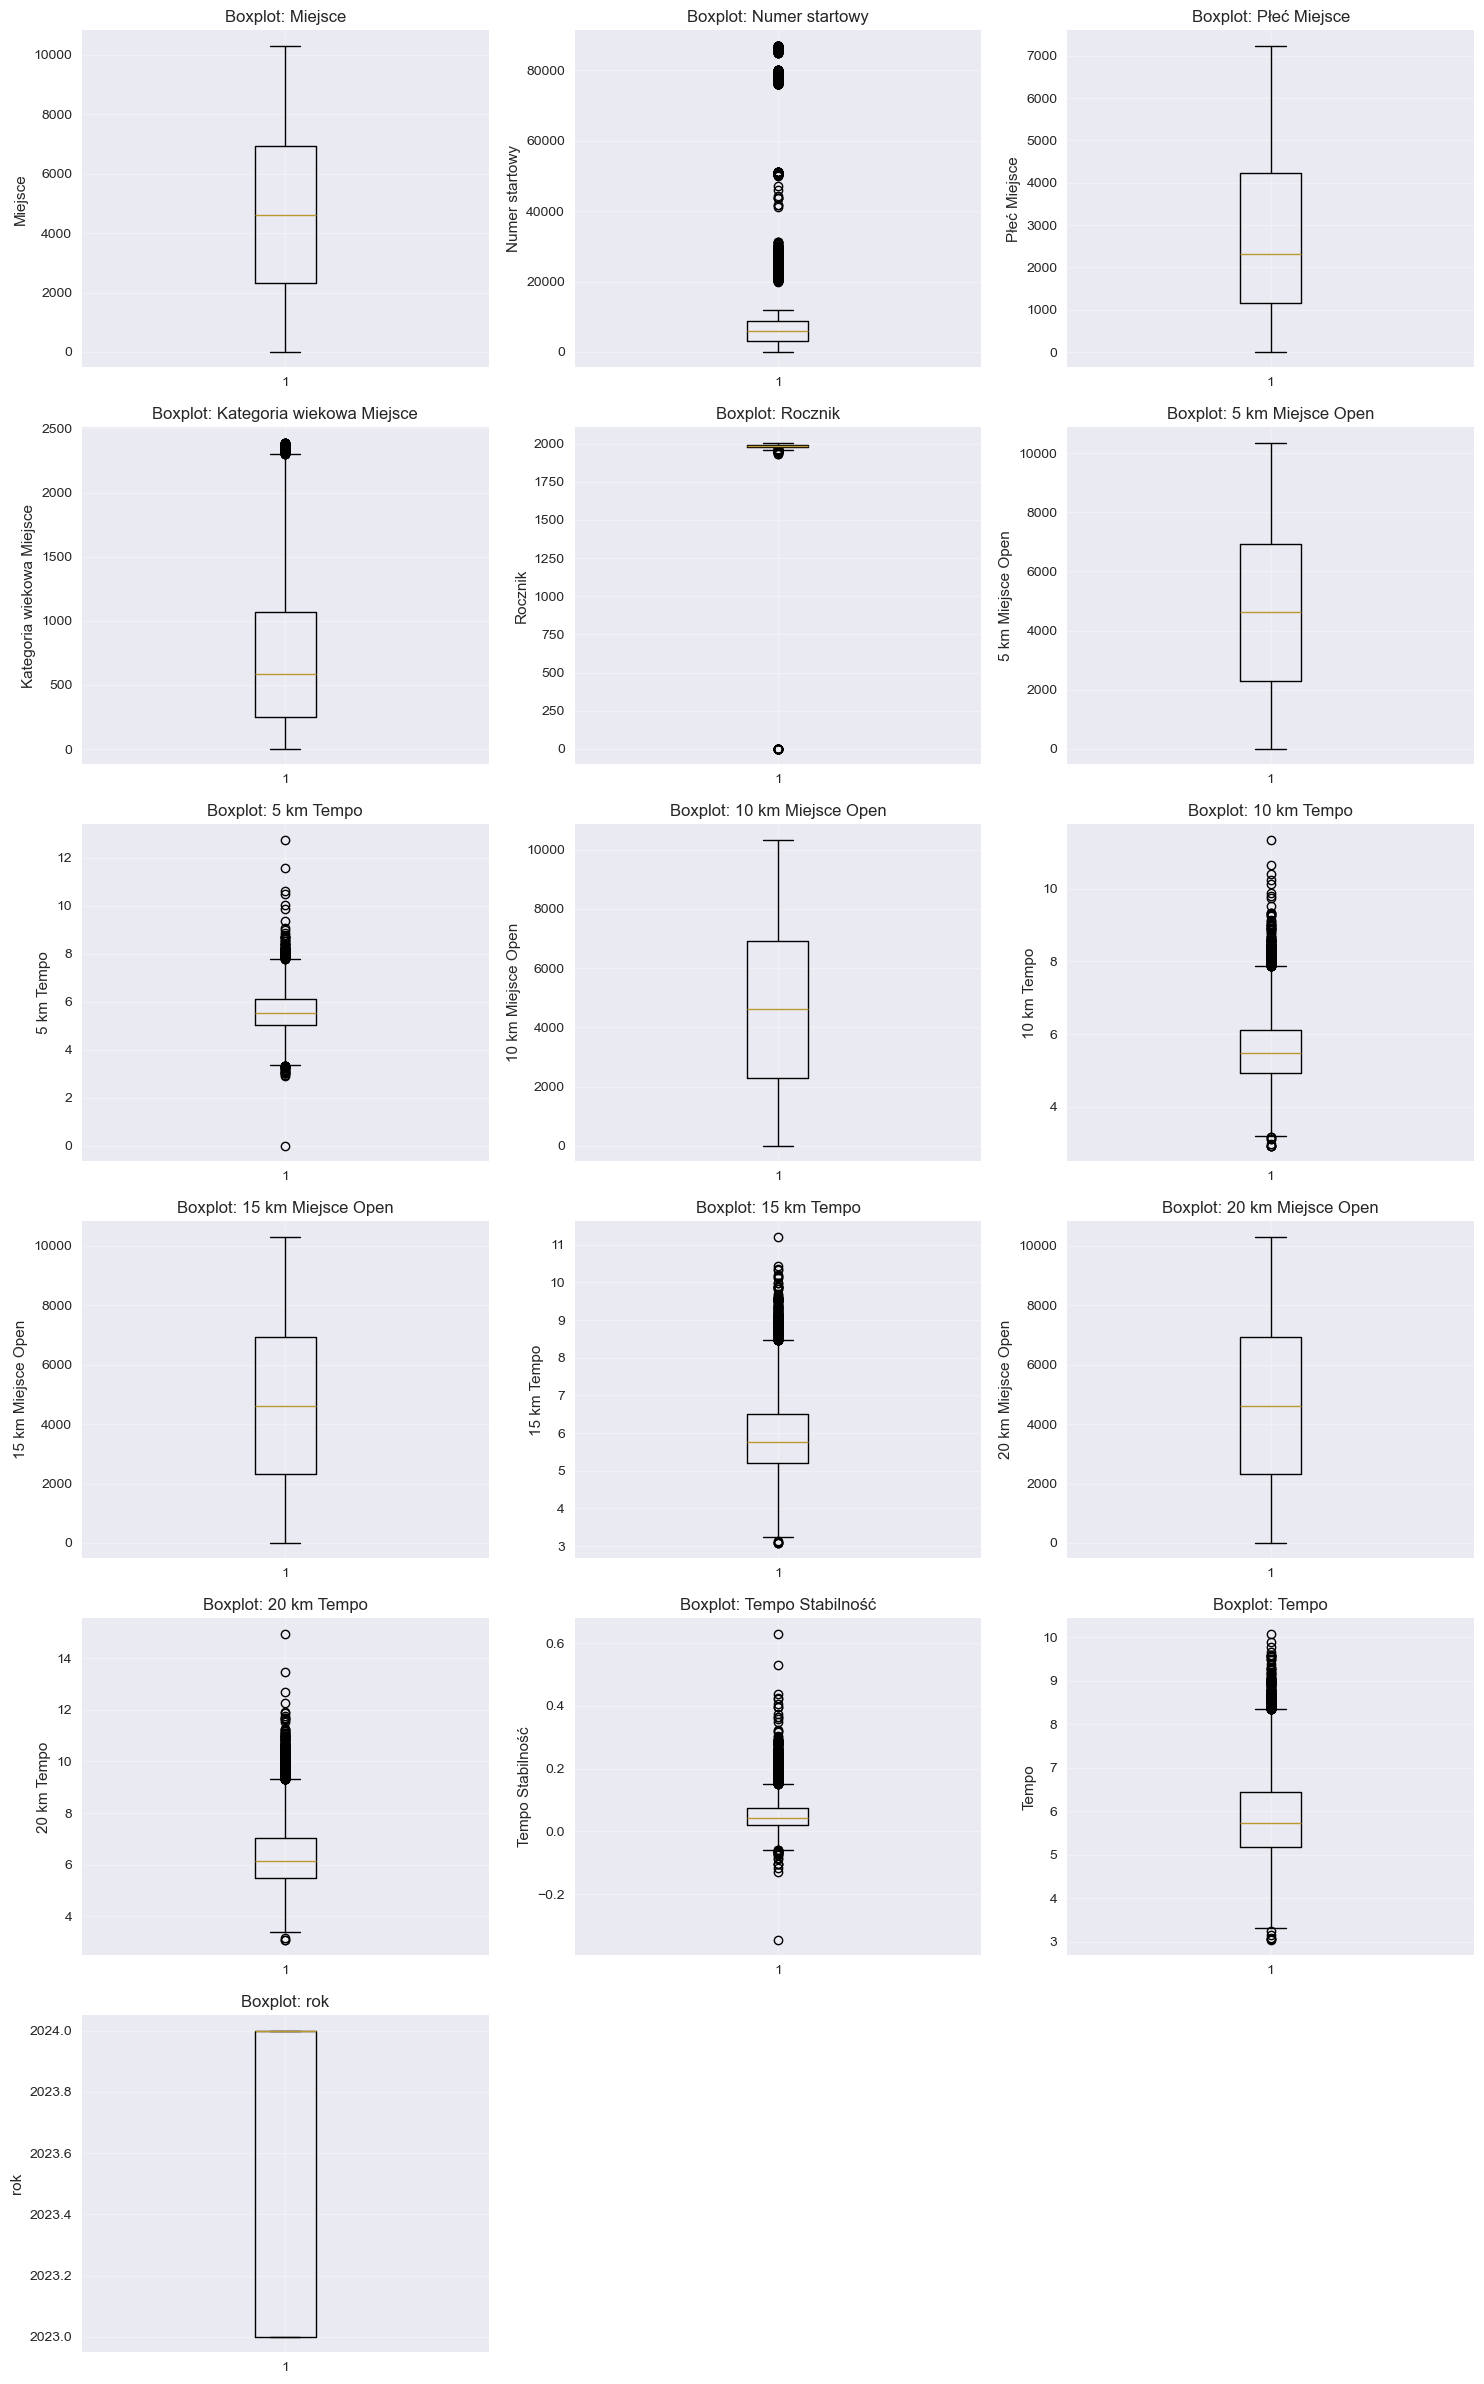

✓ Wykres zapisany w: plots\boxplots.png


In [16]:
# Boxploty dla zmiennych numerycznych (wykrycie outlierów)
# Stwórz subploty
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

# Dla każdej zmiennej numerycznej narysuj boxplot
for idx, col in enumerate(numeric_cols):
    # Boxplot
    axes[idx].boxplot(df[col].dropna(), vert=True)
    axes[idx].set_title(f'Boxplot: {col}')
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3)

# Ukryj niewykorzystane subploty
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].set_visible(False)

# Dopasuj layout
plt.tight_layout()
# Zapisz wykres
plt.savefig(os.path.join(PLOTS_DIR, 'boxplots.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Wykres zapisany w: {os.path.join(PLOTS_DIR, 'boxplots.png')}")

### 💡 Wnioski z boxplotów:

**Czego się spodziewamy:**
- **Miejsca** - brak outliers (każde miejsce 1-21957 jest poprawne)
- **Rocznik** - możliwe outliers (bardzo młodzi/starzy zawodnicy)
- **Tempo** - outliers możliwe (bardzo szybcy/wolni)
- **Czasy pośrednie** - outliers mogą wskazywać na:
  - Elitarnych zawodników (bardzo szybko)
  - Kontuzje/przejścia (bardzo wolno)
  - Błędy pomiaru

**Decyzja:** Nie usuwamy outliers - mogą być prawdziwymi danymi!

### 📦 Boxplot - Wykrywanie Wartości Odstających

**Jak czytać boxplot:**
- **Pudełko** = 50% środkowych danych (25%-75%)
- **Linia w środku** = mediana (50%)
- **Wąsy** = zakres "normalnych" wartości
- **Kropki powyżej/poniżej** = outliers (wartości odstające)

**Outliers:**
- Mogą być błędami w danych
- Mogą być prawdziwymi ekstremalnymi przypadkami
- Decyzja: usunąć czy zostawić?

**Dla półmaratonu:**
- Extremalne czasy mogą być uzasadnione (elitarni zawodnicy vs osoby spacerujące)

## 7. Analiza Korelacji

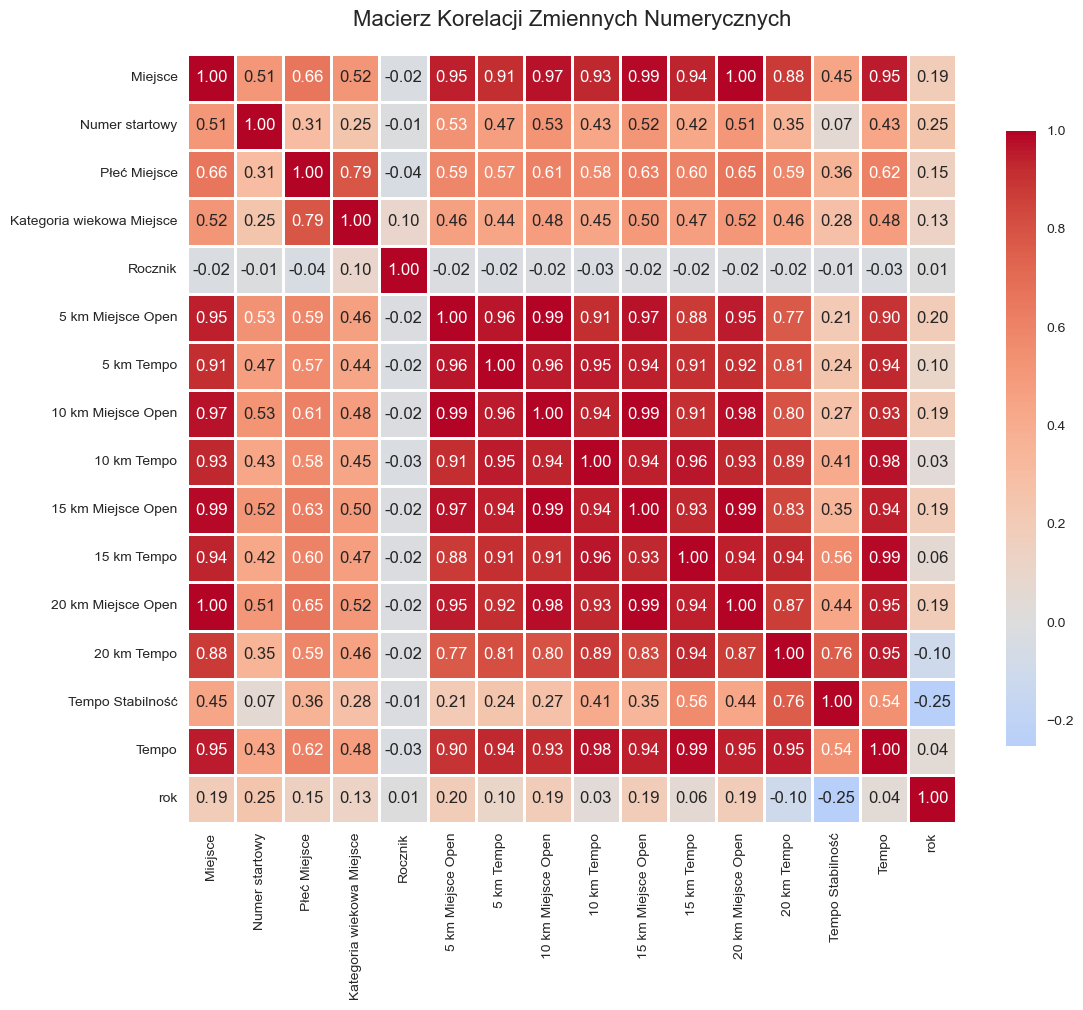

✓ Wykres zapisany w: plots\correlation_matrix.png


In [89]:
# Macierz korelacji dla zmiennych numerycznych
correlation_matrix = df[numeric_cols].corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(12, 10))
# Heatmapa z wartościami korelacji
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Macierz Korelacji Zmiennych Numerycznych', fontsize=16, pad=20)
plt.tight_layout()
# Zapisz wykres
plt.savefig(os.path.join(PLOTS_DIR, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Wykres zapisany w: {os.path.join(PLOTS_DIR, 'correlation_matrix.png')}")

## 8. Analiza Zmiennych Kategorycznych

In [90]:
# Wybierz kolumny kategoryczne (object/string)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Analiza unikalnych wartości dla każdej zmiennej kategorycznej
print("Analiza zmiennych kategorycznych:")
for col in categorical_cols:
    n_unique = df[col].nunique()
    print(f"\n{col}:")
    print(f"  Liczba unikalnych wartości: {n_unique}")
    
    # Jeśli jest mało unikalnych wartości, wyświetl rozkład
    if n_unique <= 20:
        print(f"  Rozkład wartości:")
        value_counts = df[col].value_counts()
        for val, count in value_counts.items():
            print(f"    {val}: {count} ({count/len(df)*100:.2f}%)")

Analiza zmiennych kategorycznych:

Imię:
  Liczba unikalnych wartości: 975

Nazwisko:
  Liczba unikalnych wartości: 10274

Miasto:
  Liczba unikalnych wartości: 2170

Kraj:
  Liczba unikalnych wartości: 43

Drużyna:
  Liczba unikalnych wartości: 4035

Płeć:
  Liczba unikalnych wartości: 2
  Rozkład wartości:
    M: 15339 (69.86%)
    K: 6607 (30.09%)

Kategoria wiekowa:
  Liczba unikalnych wartości: 13
  Rozkład wartości:
    M40: 5157 (23.49%)
    M30: 4953 (22.56%)
    M20: 2736 (12.46%)
    K30: 2357 (10.73%)
    K40: 2224 (10.13%)
    M50: 1710 (7.79%)
    K20: 1373 (6.25%)
    M60: 643 (2.93%)
    K50: 519 (2.36%)
    M70: 116 (0.53%)
    K60: 114 (0.52%)
    K70: 19 (0.09%)
    M80: 5 (0.02%)

5 km Czas:
  Liczba unikalnych wartości: 1331

10 km Czas:
  Liczba unikalnych wartości: 2497

15 km Czas:
  Liczba unikalnych wartości: 3650

20 km Czas:
  Liczba unikalnych wartości: 4825

Czas:
  Liczba unikalnych wartości: 5042


### 💡 Wnioski z macierzy korelacji:

**Spodziewane silne korelacje:**

1. **Czasy na punktach kontrolnych** ↔ **Miejsce**
   - Im szybszy na 5km, 10km, 15km → tym lepsze miejsce
   - Korelacja prawdopodobnie ~0.8-0.9

2. **Tempo** ↔ **Czasy pośrednie**
   - Zawodnicy z szybkim tempem mają lepsze czasy
   - Bardzo silna korelacja

3. **Miejsce** ↔ **Miejsce w kategorii**
   - Te zmienne są prawie identyczne
   - Multikolinearność - możemy usunąć jedną

4. **Rocznik** ↔ **Kategoria wiekowa**
   - Oczywiście skorelowane (kategoria bazuje na wieku)

**Co to oznacza:**
- Czasy pośrednie będą kluczowe dla predykcji!
- Niektóre zmienne są redundantne (można usunąć)

### 🔗 Macierz Korelacji - Zależności Między Zmiennymi

**Korelacja = jak silnie dwie zmienne są ze sobą powiązane**

**Skala korelacji:**
- **+1.0** = idealna dodatnia korelacja (jak jedna rośnie, druga też)
- **0.0** = brak korelacji (zmienne niezależne)
- **-1.0** = idealna ujemna korelacja (jak jedna rośnie, druga maleje)

**Kolory:**
- 🔴 Czerwony = wysoka dodatnia korelacja
- 🔵 Niebieski = wysoka ujemna korelacja
- ⚪ Biały = brak korelacji

**Co szukamy:**
- Silne korelacje z zmienną docelową (Czas)
- Multikolinearność (zmienne bardzo skorelowane między sobą - może być problem)

### 🏷️ Zmienne Kategoryczne - Analiza Unikalnych Wartości

**Zmienne kategoryczne = etykiety, grupy, kategorie**

**Przykłady:**
- Płeć (M/K)
- Kraj (Polska, Niemcy, Czechy...)
- Kategoria wiekowa (M20, M30, K40...)
- Miasto (Wrocław, Warszawa...)

**Kardinalność = liczba unikalnych wartości**
- **Niska** (2-20) - dobrze dla modelu, można łatwo zakodować
- **Wysoka** (>100) - problem, model może się "pogubić"

**Co sprawdzamy:**
- Ile unikalnych wartości?
- Czy jest dominująca kategoria? (np. 90% to "M")
- Czy są kategorie z małą liczbą przykładów?

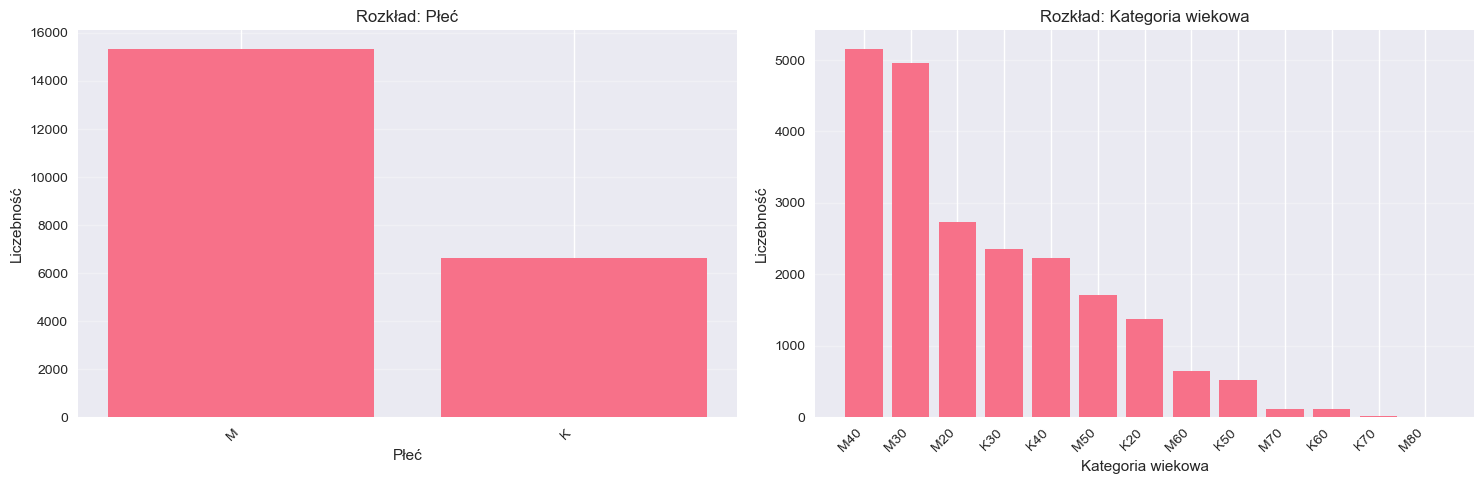

✓ Wykres zapisany w: plots\categorical_distributions.png


In [20]:
# Wykresy słupkowe dla zmiennych kategorycznych (tylko te z małą liczbą unikalnych wartości)
# Wybierz zmienne z max 20 unikalnymi wartościami
cat_cols_to_plot = [col for col in categorical_cols if df[col].nunique() <= 20]

if cat_cols_to_plot:
    # Oblicz liczbę wierszy i kolumn dla subplotów
    n_cols_cat = 2
    n_rows_cat = (len(cat_cols_to_plot) + n_cols_cat - 1) // n_cols_cat
    
    # Stwórz figurę
    fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(15, n_rows_cat * 5))
    axes = axes.flatten() if n_rows_cat > 1 else [axes] if n_cols_cat == 1 else axes
    
    # Dla każdej zmiennej kategorycznej narysuj wykres słupkowy
    for idx, col in enumerate(cat_cols_to_plot):
        # Zlicz wartości
        value_counts = df[col].value_counts()
        # Wykres słupkowy
        axes[idx].bar(range(len(value_counts)), value_counts.values)
        axes[idx].set_title(f'Rozkład: {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Liczebność')
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Ukryj niewykorzystane subploty
    for idx in range(len(cat_cols_to_plot), len(axes)):
        axes[idx].set_visible(False)
    
    # Dopasuj layout
    plt.tight_layout()
    # Zapisz wykres
    plt.savefig(os.path.join(PLOTS_DIR, 'categorical_distributions.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Wykres zapisany w: {os.path.join(PLOTS_DIR, 'categorical_distributions.png')}")
else:
    print("Brak zmiennych kategorycznych z małą liczbą unikalnych wartości do wizualizacji")

### 💡 Wnioski z wykresów słupkowych:

**Spodziewane obserwacje:**

1. **Płeć:**
   - Prawdopodobnie więcej mężczyzn (M) niż kobiet (K)
   - Półmaratony mają zazwyczaj ~60-70% mężczyzn

2. **Kategoria wiekowa:**
   - Najwięcej zawodników w kategoriach M30-M40, K30-K40
   - Mniej w kategoriach młodszych (M20, K20) i starszych (M60+)

3. **Kraj:**
   - Dominacja Polski (to bieg we Wrocławiu!)
   - Pojedynczy zawodnicy z krajów sąsiednich

4. **Kategoria wiekowa miejsca:**
   - Równomierny rozkład (każda kategoria ma swoją klasyfikację)

**Decyzje dla modelu:**
- **Płeć i Kategoria wiekowa** - ZOSTAJĄ (mały wpływ, łatwe do zakodowania)
- **Miasto i Drużyna** - USUNĄĆ (zbyt wiele unikalnych, 60% braków)
- **Kraj** - ZOSTAWIĆ (może mieć wpływ, niewiele kategorii)

## 9. Podsumowanie EDA

In [21]:
# Podsumowanie najważniejszych informacji o danych
print("="*50)
print("PODSUMOWANIE EKSPLORACJI DANYCH")
print("="*50)
print(f"\n1. Rozmiar datasetu: {df.shape[0]} wierszy, {df.shape[1]} kolumn")
print(f"\n2. Zmienne numeryczne: {len(numeric_cols)}")
print(f"   {', '.join(numeric_cols)}")
print(f"\n3. Zmienne kategoryczne: {len(categorical_cols)}")
print(f"   {', '.join(categorical_cols)}")
print(f"\n4. Brakujące wartości: {df.isnull().sum().sum()} (w {(df.isnull().sum() > 0).sum()} kolumnach)")
print(f"\n5. Duplikaty: {duplicates}")
print("\n" + "="*50)

PODSUMOWANIE EKSPLORACJI DANYCH

1. Rozmiar datasetu: 21957 wierszy, 28 kolumn

2. Zmienne numeryczne: 16
   Miejsce, Numer startowy, Płeć Miejsce, Kategoria wiekowa Miejsce, Rocznik, 5 km Miejsce Open, 5 km Tempo, 10 km Miejsce Open, 10 km Tempo, 15 km Miejsce Open, 15 km Tempo, 20 km Miejsce Open, 20 km Tempo, Tempo Stabilność, Tempo, rok

3. Zmienne kategoryczne: 12
   Imię, Nazwisko, Miasto, Kraj, Drużyna, Płeć, Kategoria wiekowa, 5 km Czas, 10 km Czas, 15 km Czas, 20 km Czas, Czas

4. Brakujące wartości: 83888 (w 24 kolumnach)

5. Duplikaty: 0



## 10. Przygotowanie Danych - Konwersja Czasu na Sekundy

**Cel:** Przekształcić zmienną docelową (Czas) oraz czas na 5km z formatu tekstowego (H:MM:SS) na liczbę sekund.

**Dlaczego?**
- Modele ML wymagają danych **numerycznych**, nie tekstowych
- Sekundy to bardziej naturalna jednostka dla regresji
- Łatwiejsza interpretacja błędów (MAE w sekundach = ile sekund się pomyliliśmy)
- Format tekstowy byłby traktowany jako zmienna kategoryczna (model nie rozumiałby że 00:30:00 < 01:00:00)

**Uwaga:** W kroku 11 przekonwertujemy także czas 5km na sekundy dla spójności.

In [121]:
def time_to_seconds(time_str):
    """Konwertuje czas w formacie H:MM:SS lub MM:SS na sekundy
    
    Obsługuje:
    - Format HH:MM:SS (godziny:minuty:sekundy)
    - Format MM:SS (minuty:sekundy)
    - Wartości NaN/None (zwraca None)
    - Nieprawidłowe formaty (zwraca None)
    """
    # Obsługa wartości None lub NaN
    if pd.isna(time_str) or time_str is None:
        return None
    
    # Jeśli to nie jest string (np. float), zwróć None
    if not isinstance(time_str, str):
        return None
    
    try:
        parts = time_str.strip().split(':')
        
        if len(parts) == 3:
            # Format HH:MM:SS
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = int(parts[2])
            return hours * 3600 + minutes * 60 + seconds
        elif len(parts) == 2:
            # Format MM:SS (bez godzin)
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
        else:
            return None
    except (ValueError, AttributeError):
        return None

# Tworzenie nowej kolumny z czasem w sekundach
df_processed = df.copy()
df_processed['Czas_sekundy'] = df_processed['Czas'].apply(time_to_seconds)

# Usunięcie wierszy z błędnymi wartościami czasu
df_processed = df_processed.dropna(subset=['Czas_sekundy'])

print(f"✓ Przekonwertowano czas na sekundy")
print(f"✓ Zakres czasów: {df_processed['Czas_sekundy'].min()//60:.0f} - {df_processed['Czas_sekundy'].max()//60:.0f} minut")
print(f"✓ Średni czas: {df_processed['Czas_sekundy'].mean()//60:.0f} minut ({df_processed['Czas_sekundy'].mean():.0f} sekund)")

✓ Przekonwertowano czas na sekundy
✓ Zakres czasów: 64 - 212 minut
✓ Średni czas: 123 minut (7408 sekund)


## 11. ⚠️ Wykrywanie i Eliminacja Data Leakage

### Co to jest Data Leakage?

**Data leakage** = sytuacja, gdy model ma dostęp do informacji, których NIE MIAŁBY w momencie rzeczywistej predykcji.

**Analogia z egzaminem:**
- ✅ Uczenie się z podręczników = OK (dane treningowe)
- ❌ Podglądanie odpowiedzi podczas testu = CHEATING (data leakage)

**Use case:** Przewidujemy końcowy czas zawodnika, który jest właśnie na punkcie 5km.

**Features (dane wejściowe):**
- ✅ Płeć, Rocznik, Kraj, Kategoria = znane przed startem
- ✅ **Czas na 5km** = znany W MOMENCIE predykcji (zawodnik właśnie minął 5km)

**Data leakage (informacje z przyszłości):**
- ❌ Czasy na 10km, 15km, 20km = znane PÓŹNIEJ (po 5km)
- ❌ Tempo końcowe = wyliczone PO zakończeniu biegu
- ❌ Miejsce w klasyfikacji = znane PO zakończeniu biegu

**Nasz cel:**
Model przewiduje: "Zawodnik ma czas X na 5km → jaki będzie jego końcowy czas?"

In [122]:
# Sprawdzenie, jakie kolumny mamy w datasecie
print("Aktualne kolumny w df_processed:")
print(df_processed.columns.tolist())

Aktualne kolumny w df_processed:
['Miejsce', 'Numer startowy', 'Imię', 'Nazwisko', 'Miasto', 'Kraj', 'Drużyna', 'Płeć', 'Płeć Miejsce', 'Kategoria wiekowa', 'Kategoria wiekowa Miejsce', 'Rocznik', '5 km Czas', '5 km Miejsce Open', '5 km Tempo', '10 km Czas', '10 km Miejsce Open', '10 km Tempo', '15 km Czas', '15 km Miejsce Open', '15 km Tempo', '20 km Czas', '20 km Miejsce Open', '20 km Tempo', 'Tempo Stabilność', 'Czas', 'Tempo', 'rok', '5km_sekundy', 'Czas_sekundy']


### 🔍 Identyfikacja Kolumn z Data Leakage

**Kolumny BEZPIECZNE (znane przed lub na 5km):**
- `Płeć` → znana przed biegiem
- `Rocznik` → rok urodzenia (znany przed biegiem)
- `Kategoria wiekowa` → wyliczona z rocznika (pomocnicza, ale redundantna)
- `Kraj` → narodowość (pomocnicza, ale może być szumem)
- `5 km` / `5km` → **ZACHOWUJEMY!** Czas na 5km (kluczowa cecha)
- `Czas_sekundy` → nasza zmienna docelowa (TARGET)

**⚠️ UWAGA:** Na tym etapie zachowujemy wszystkie bezpieczne kolumny. Wybór finalnych 3 cech nastąpi w dalszej części tego kroku.

**Słowa kluczowe DATA LEAKAGE (usuwamy):**
- `10 km`, `10km` → znane PÓŹNIEJ niż 5km
- `15 km`, `15km` → znane PÓŹNIEJ niż 5km
- `20 km`, `20km` → znane PÓŹNIEJ niż 5km
- `tempo` → tempo końcowe (znane po biegu)
- `pace` → tempo po angielsku
- `miejsce` → miejsce w klasyfikacji (znane po biegu)

- `place` → miejsce po angielsku- `stabilność` → stabilność tempa (wyliczona po biegu)

In [123]:
# Definicja słów kluczowych identyfikujących data leakage
# UWAGA: Usuwamy tylko czasy PÓŹNIEJSZE niż 5km!
leakage_keywords = ['10 km', '10km', '15 km', '15km', '20 km', '20km', 
                    'tempo', 'pace', 'miejsce', 'place', 'stabilność']

# Znalezienie kolumn zawierających te słowa kluczowe
leakage_columns = []
for col in df_processed.columns:
    col_lower = col.lower()
    for keyword in leakage_keywords:
        if keyword in col_lower:
            leakage_columns.append(col)
            break

print(f"🚫 Kolumny z data leakage (usuwamy) ({len(leakage_columns)}):")
for col in leakage_columns:
    print(f"   - {col}")

# Definiujemy kolumny BEZPIECZNE (znane w momencie predykcji)
# DODAJEMY CZAS NA 5KM jako feature!
safe_base_columns = ['Płeć', 'Rocznik', 'Kategoria wiekowa', 'Kraj', 'Czas_sekundy']

# Szukamy kolumny z czasem na 5km (może być różnie nazwana)
time_5km_col = None
for col in df_processed.columns:
    if '5' in col and 'km' in col.lower():
        time_5km_col = col
        break

# Dodajemy kolumnę 5km jeśli istnieje
if time_5km_col:
    print(f"\n✅ Znaleziono kolumnę z czasem na 5km: '{time_5km_col}'")
    
    # ⚠️ KONWERSJA CZASU 5KM NA SEKUNDY (format numeryczny dla modelu)
    print(f"\n🔄 Konwersja '{time_5km_col}' z formatu HH:MM:SS na sekundy...")
    
    # Użyjemy tej samej funkcji time_to_seconds co wcześniej
    df_processed['5 km Czas_sekundy'] = df_processed[time_5km_col].apply(time_to_seconds)
    
    # Sprawdź wyniki konwersji
    successful_conversions = df_processed['5 km Czas_sekundy'].notna().sum()
    failed_conversions = df_processed['5 km Czas_sekundy'].isna().sum()
    
    print(f"   ✓ Przekonwertowano: {successful_conversions:,} wartości")
    if failed_conversions > 0:
        print(f"   ⚠️ Niepoprawne wartości: {failed_conversions}")
    print(f"   ✓ Zakres: {df_processed['5 km Czas_sekundy'].min():.0f}s - {df_processed['5 km Czas_sekundy'].max():.0f}s")
    print(f"   ✓ Średnia: {df_processed['5 km Czas_sekundy'].mean():.0f}s ({df_processed['5 km Czas_sekundy'].mean()/60:.1f} min)")
    
    # Dodaj kolumnę numeryczną zamiast tekstowej
    safe_base_columns.insert(1, '5 km Czas_sekundy')  # Dodaj kolumnę z sekundami
    print(f"\n✅ Dodano kolumnę numeryczną: '5 km Czas_sekundy' (zamiast tekstowej '{time_5km_col}')")
else:
    print(f"\n⚠️ UWAGA: Nie znaleziono kolumny z czasem na 5km!")

# Sprawdzamy, które z bezpiecznych kolumn rzeczywiście istnieją
available_safe_columns = [col for col in safe_base_columns if col in df_processed.columns]

print(f"\n✅ Features do modelu ({len(available_safe_columns)}):")
for col in available_safe_columns:
    if col == 'Czas_sekundy':
        print(f"   - {col} ← TARGET (zmienna docelowa)")
    elif col == '5 km Czas_sekundy':
        print(f"   - {col} ← Czas na 5km w sekundach (kluczowy feature, format NUMERYCZNY!)")
    else:
        print(f"   - {col}")

# Tworzymy nowy dataset bez data leakage
df_clean = df_processed[available_safe_columns].copy()

print(f"\n✓ Utworzono df_clean z {df_clean.shape[1]} kolumnami")
print(f"✓ Liczba wierszy: {df_clean.shape[0]:,}")
print(f"\n📋 Dataset df_clean zawiera kolumny: {[col for col in df_clean.columns if col != 'Czas_sekundy']}")
print(f"🎯 Zmienna docelowa: Czas_sekundy (końcowy czas)")
print(f"\n⚠️ UWAGA: To pełny dataset po eliminacji data leakage.")
print(f"   Finalne 3 cechy zostaną wybrane w dalszej części tego kroku.")

🚫 Kolumny z data leakage (usuwamy) (16):
   - Miejsce
   - Płeć Miejsce
   - Kategoria wiekowa Miejsce
   - 5 km Miejsce Open
   - 5 km Tempo
   - 10 km Czas
   - 10 km Miejsce Open
   - 10 km Tempo
   - 15 km Czas
   - 15 km Miejsce Open
   - 15 km Tempo
   - 20 km Czas
   - 20 km Miejsce Open
   - 20 km Tempo
   - Tempo Stabilność
   - Tempo

✅ Znaleziono kolumnę z czasem na 5km: '5 km Czas'

🔄 Konwersja '5 km Czas' z formatu HH:MM:SS na sekundy...
   ✓ Przekonwertowano: 18,411 wartości
   ⚠️ Niepoprawne wartości: 39
   ✓ Zakres: 0s - 3825s
   ✓ Średnia: 1676s (27.9 min)

✅ Dodano kolumnę numeryczną: '5 km Czas_sekundy' (zamiast tekstowej '5 km Czas')

✅ Features do modelu (6):
   - Płeć
   - 5 km Czas_sekundy ← Czas na 5km w sekundach (kluczowy feature, format NUMERYCZNY!)
   - Rocznik
   - Kategoria wiekowa
   - Kraj
   - Czas_sekundy ← TARGET (zmienna docelowa)

✓ Utworzono df_clean z 6 kolumnami
✓ Liczba wierszy: 18,450

📋 Dataset df_clean zawiera kolumny: ['Płeć', '5 km Czas_sek

In [124]:
# Finalne czyszczenie df_clean
print("📋 Finalne czyszczenie datasetu...")
initial_size = len(df_clean)
df_clean = df_clean.dropna(subset=['Czas_sekundy'])
removed_rows = initial_size - len(df_clean)
print(f"✓ Usunięto {removed_rows} wierszy bez wartości docelowej")
print(f"  Pozostało: {len(df_clean):,} wierszy\n")

# Wyświetl finalne informacje o datasecie
print("=" * 60)
print("📊 DATASET PO ELIMINACJI DATA LEAKAGE (df_clean)")
print("=" * 60)
print(f"Rozmiar: {df_clean.shape[0]:,} wierszy × {df_clean.shape[1]} kolumn")
print(f"\n✅ Kolumny (wszystkie bezpieczne - bez data leakage):")
for col in df_clean.columns:
    if col == 'Czas_sekundy':
        continue
    if df_clean[col].dtype == 'object':
        n_unique = df_clean[col].nunique()
        print(f"   • {col:25} (kategoryczna, {n_unique} unikalnych wartości)")
    else:
        mean_val = df_clean[col].mean()
        print(f"   • {col:25} (numeryczna, średnia: {mean_val:.1f})")

print(f"\n🎯 Target (zmienna docelowa):")
print(f"   • Czas_sekundy (średnia: {df_clean['Czas_sekundy'].mean():.0f}s = {df_clean['Czas_sekundy'].mean()/60:.1f} min)")
print("\n⚠️ UWAGA: To pełny dataset. Wybór finalnych 3 cech nastąpi dalej.")
print("=" * 60)

📋 Finalne czyszczenie datasetu...
✓ Usunięto 0 wierszy bez wartości docelowej
  Pozostało: 18,450 wierszy

📊 DATASET PO ELIMINACJI DATA LEAKAGE (df_clean)
Rozmiar: 18,450 wierszy × 6 kolumn

✅ Kolumny (wszystkie bezpieczne - bez data leakage):
   • Płeć                      (kategoryczna, 2 unikalnych wartości)
   • 5 km Czas_sekundy         (numeryczna, średnia: 1675.9)
   • Rocznik                   (numeryczna, średnia: 1982.2)
   • Kategoria wiekowa         (kategoryczna, 13 unikalnych wartości)
   • Kraj                      (kategoryczna, 43 unikalnych wartości)

🎯 Target (zmienna docelowa):
   • Czas_sekundy (średnia: 7408s = 123.5 min)

⚠️ UWAGA: To pełny dataset. Wybór finalnych 3 cech nastąpi dalej.


### ✅ Podsumowanie przygotowania danych

**Wykonaliśmy trzy kluczowe kroki:**

**Krok 1: Eliminacja Data Leakage**
- Usunęliśmy kolumny zawierające informacje **nieznane w momencie predykcji na 5km**
- Kolumny usunięte: czasy na 10km, 15km, 20km, miejsca w klasyfikacji, tempo końcowe
- Kolumny **zachowane**: Płeć, Rocznik, Kategoria wiekowa, Kraj, **5 km Czas** ← kluczowy!
- Utworzono dataset `df_clean` (pełny, po eliminacji data leakage)

**Krok 2: Finalne czyszczenie**  
- Usunęliśmy wiersze bez wartości docelowej (brakujący czas końcowy)
- Dataset `df_clean` jest kompletny i gotowy

**Krok 3: Wybór finalnych cech do trenowania**
- Wybraliśmy **tylko 3 kluczowe cechy**: Płeć, 5 km Czas, Rocznik
- Odrzuciliśmy cechy redundantne (Kategoria wiekowa - wynika z rocznika)
- Odrzuciliśmy cechy szumne (Kraj - zbyt wiele wartości, mała liczebność)
- Utworzono dataset `df_model` z 3 cechami → gotowy do trenowania modelu!

**💡 Dlaczego ta kolejność?**
1. Najpierw usuwamy data leakage → zachowujemy tylko to, co będzie znane w rzeczywistości

2. Potem czyścimy braki → finalizujemy dataset tylko z kompletnymi danymi  3. Na koniec wybieramy optymalne cechy → prostszy, lepszy model

In [125]:
# Przygotowanie datasetu z tylko 3 kluczowymi cechami
print("=" * 80)
print("🔄 PRZYGOTOWANIE DANYCH - MODEL Z 3 CECHAMI")
print("=" * 80)

# Wybierz tylko najważniejsze cechy
selected_features = ['Płeć', '5 km Czas_sekundy', 'Rocznik']  # 3 kluczowe cechy (⚠️ UWAGA: Czas w SEKUNDACH, nie tekst!)
target = 'Czas_sekundy'  # Zmienna docelowa

# Stwórz nowy DataFrame z wybranymi cechami
df_model = df_clean[selected_features + [target]].copy()  # Kopia aby nie modyfikować oryginału

print(f"\n✓ Dataset przygotowany:")
print(f"  • Cechy wejściowe: {', '.join(selected_features)}")
print(f"  • Zmienna docelowa: {target}")
print(f"  • Liczba rekordów: {len(df_model):,}")
print(f"  • Liczba cech: {len(selected_features)}")

# Sprawdź brakujące wartości
missing_model = df_model.isnull().sum()  # Suma braków dla każdej kolumny
if missing_model.sum() > 0:  # Jeśli są jakieś braki
    print(f"\n⚠️ Brakujące wartości:")
    print(missing_model[missing_model > 0])  # Wyświetl tylko kolumny z brakami
else:
    print(f"\n✓ Brak brakujących wartości - dataset kompletny!")

# Podgląd danych
print(f"\n📊 Pierwsze 5 wierszy:")
print(df_model.head())

# Statystyki zmiennej docelowej
print(f"\n📈 Statystyki zmiennej docelowej (Czas_sekundy):")
print(f"  • Średnia: {df_model[target].mean():.0f}s ({df_model[target].mean()/60:.1f} min)")
print(f"  • Mediana: {df_model[target].median():.0f}s ({df_model[target].median()/60:.1f} min)")
print(f"  • Min: {df_model[target].min():.0f}s ({df_model[target].min()/60:.1f} min)")
print(f"  • Max: {df_model[target].max():.0f}s ({df_model[target].max()/60:.1f} min)")

print("\n" + "=" * 80)

🔄 PRZYGOTOWANIE DANYCH - MODEL Z 3 CECHAMI

✓ Dataset przygotowany:
  • Cechy wejściowe: Płeć, 5 km Czas_sekundy, Rocznik
  • Zmienna docelowa: Czas_sekundy
  • Liczba rekordów: 18,450
  • Liczba cech: 3

⚠️ Brakujące wartości:
5 km Czas_sekundy     39
Rocznik              485
dtype: int64

📊 Pierwsze 5 wierszy:
  Płeć  5 km Czas_sekundy  Rocznik  Czas_sekundy
0    M              877.0   1992.0        3899.0
1    M              888.0   1986.0        3983.0
2    M              946.0   1996.0        4104.0
3    M              971.0   1988.0        4216.0
4    M              972.0   1995.0        4227.0

📈 Statystyki zmiennej docelowej (Czas_sekundy):
  • Średnia: 7408s (123.5 min)
  • Mediana: 7256s (120.9 min)
  • Min: 3843s (64.0 min)
  • Max: 12754s (212.6 min)



---

### 🎯 Wybór Najważniejszych Cech - Dlaczego tylko 3 cechy?

**Na podstawie analizy danych i wiedzy domenowej wybraliśmy 3 kluczowe cechy:**

1. **⏱️ Czas na 5 km (w sekundach)** - NAJWAŻNIEJSZY predyktor
   - **Format numeryczny** (np. 1800 sekund = 30 minut) - umożliwia modelowi zrozumienie relacji czasowych
   - Bezpośredni wskaźnik formy zawodnika w dniu biegu
   - Tempo na 5km mocno koreluje z tempem końcowym
   - Większość zawodników utrzymuje stabilne tempo przez cały bieg

2. **🎂 Rocznik (wiek)** - drugorzędny predyktor
   - Wydolność fizyczna zmienia się z wiekiem
   - Szczyt formy: ~25-35 lat
   - Po 40 roku życia tempo zwykle maleje o ~1-2% rocznie

3. **👤 Płeć** - podstawowy predyktor fizjologiczny
   - Średnie tempo mężczyzn vs kobiet różni się o ~15-20%
   - Różnice w fizjologii (V̇O₂max, masa mięśniowa)

**❌ Cechy które ODRZUCAMY (i dlaczego):**

- **Kategoria wiekowa** 
  - ❌ Redundantna - obliczana z rocznika (duplikacja informacji)
  - ❌ Model automatycznie wyliczy wpływ wieku z rocznika

- **Kraj**
  - ❌ Zbyt wiele unikalnych wartości (>50 krajów)
  - ❌ Małe liczebności dla większości krajów (szum statystyczny)
  - ❌ Nie ma sensu fizjologicznego - narodowość nie determinuje tempa
  - ❌ Po encoding tworzy dziesiątki dodatkowych kolumn

- **Inne kolumny czasowe** (10km, 15km, 20km, Czas końcowy)
  - ❌ Data leakage - nieznane w momencie predykcji na 5km
  - ❌ Już usunięte w poprzednich krokach

**💡 Prostszy model = lepszy model:**
- Mniej ryzyka przeuczenia (overfitting)
- Szybsze predykcje
- Łatwiejsza interpretacja


- Mniej inputów od użytkownika- Format numeryczny pozwala modelowi zrozumieć że 1800s > 1500s (relacje matematyczne)

**⚠️ UWAGA: Format numeryczny dla czasu 5km**- Format tekstowy byłby traktowany jako kategoria (1331 unikalnych wartości)

- Używamy kolumny `'5 km Czas_sekundy'` (int) zamiast `'5 km Czas'` (string HH:MM:SS)- **Dlaczego?** Model ML potrzebuje liczb, nie tekstu!

## 12. Setup PyCaret dla Modelu - Konfiguracja Środowiska ML

In [126]:
# Inicjalizacja PyCaret dla regresji z 3 cechami
print("=" * 80)
print("⚙️ SETUP PYCARET - MODEL 3-CECHOWY")
print("=" * 80)

# Setup PyCaret
regression_setup = setup(
    data=df_model,  # Dataset z 3 cechami (Płeć, 5 km Czas_sekundy, Rocznik)
    target=target,  # Zmienna docelowa (Czas_sekundy)
    session_id=42,  # Seed dla reprodukowalności wyników
    train_size=0.8,  # 80% danych do treningu, 20% do testu
    normalize=True,  # Normalizacja zmiennych numerycznych
    transformation=False,  # Bez transformacji (np. log, sqrt)
    remove_outliers=False,  # Nie usuwaj outlierów (mogą być prawdziwe)
    remove_multicollinearity=False,  # Nie usuwaj skorelowanych cech
    fold=5,  # 5-krotna walidacja krzyżowa
    verbose=False,  # Wyłącz szczegółowe logi
    html=False,  # Wyłącz raport HTML
    memory=False,  # Wyłącz cache'owanie (obejście problemu z joblib)
)

print("\n✓ PyCaret został skonfigurowany pomyślnie")
print(f"  • Cechy: {selected_features}")
print(f"  • Target: {target}")
print(f"  • Train/Test split: 80/20")
print(f"  • Walidacja krzyżowa: 5-fold")
print("=" * 80)

⚙️ SETUP PYCARET - MODEL 3-CECHOWY

✓ PyCaret został skonfigurowany pomyślnie
  • Cechy: ['Płeć', '5 km Czas_sekundy', 'Rocznik']
  • Target: Czas_sekundy
  • Train/Test split: 80/20
  • Walidacja krzyżowa: 5-fold


### ⚙️ Co robi funkcja setup()?

**PyCaret automatyzuje preprocessing danych:**

1. **Dzieli dane** na zbiór treningowy (80%) i testowy (20%)
2. **Koduje zmienne kategoryczne** (np. "M"/"K" → 0/1)
3. **Wypełnia brakujące wartości** (imputacja - jeśli są)
4. **Normalizuje dane** (skalowanie do podobnych zakresów)
5. **Przygotowuje pipeline** gotowy do trenowania

**Dlaczego to ważne?**
- Oszczędza godziny ręcznego kodowania
- Zapobiega typowym błędom (np. data leakage)
- Zapewnia profesjonalne praktyki ML

**Po setup() mamy:**
- `X_train` - 80% danych do trenowania
- `X_test` - 20% danych do walidacji
- Pipeline gotowy do compare_models(), tune_model(), etc.

## 13. Porównanie Algorytmów - Compare Models

In [127]:
# Porównanie różnych algorytmów regresji
# PyCaret automatycznie trenuje wiele modeli i porównuje je
print("=" * 80)
print("🤖 PORÓWNANIE ALGORYTMÓW ML")
print("=" * 80)
print("\nTrenowanie wielu algorytmów na danych treningowych...")
print("To może potrwać 2-3 minuty...")
print()

# compare_models() trenuje wszystkie dostępne modele i porównuje je
# Wybieramy TOP 5 modeli - będziemy je wszystkie tuningować!
top_5_models = compare_models(
    n_select=5,  # Wybierz top 5 modeli (nie tylko 1!)
    sort='MAE',  # Sortuj według MAE (Mean Absolute Error) - mniej = lepiej
    fold=5,  # 5-krotna walidacja krzyżowa
    verbose=True  # Wyświetl postęp i wyniki
)

print("\n" + "=" * 80)
print("✓ Porównanie modeli zakończone")
print("=" * 80)

# Wyświetl typy top 5 modeli
print("\n🏆 TOP 5 MODELI wybranych do dalszego tuningu:")
for idx, model in enumerate(top_5_models, 1):
    model_name = type(model).__name__  # Pobierz nazwę klasy modelu
    print(f"  {idx}. {model_name}")

# Pobierz tabelę z wynikami compare_models()
comparison_results = pull()  # pull() pobiera ostatnie wyniki
print(f"\n📊 Szczegóły top 5 modeli:")
print(comparison_results[['Model', 'MAE', 'RMSE', 'R2', 'TT (Sec)']].head(5).to_string(index=False))

print("\n" + "=" * 80)

🤖 PORÓWNANIE ALGORYTMÓW ML

Trenowanie wielu algorytmów na danych treningowych...
To może potrwać 2-3 minuty...



                                    Model       MAE           MSE       RMSE  \
huber                     Huber Regressor  302.6722  1.944959e+05   440.9980   
par          Passive Aggressive Regressor  303.3684  1.969671e+05   443.7825   
gbr           Gradient Boosting Regressor  304.0580  1.800646e+05   424.2927   
lightgbm  Light Gradient Boosting Machine  307.0332  1.816587e+05   426.1613   
lar                Least Angle Regression  307.1762  1.922214e+05   438.4114   
lr                      Linear Regression  307.1762  1.922214e+05   438.4114   
br                         Bayesian Ridge  307.1778  1.922214e+05   438.4114   
ridge                    Ridge Regression  307.1799  1.922214e+05   438.4114   
omp           Orthogonal Matching Pursuit  307.2056  1.922712e+05   438.4678   
llar         Lasso Least Angle Regression  307.2131  1.922260e+05   438.4166   
lasso                    Lasso Regression  307.2131  1.922260e+05   438.4166   
knn                 K Neighbors Regresso

### 🤖 Dlaczego porównujemy wiele algorytmów?

**Nie wiadomo z góry który algorytm będzie najlepszy dla naszych danych!**

Różne algorytmy mają różne mocne strony:
- **Linear Regression** - prosty, szybki, dobry baseline
- **Random Forest** - dobry dla złożonych, nieliniowych zależności
- **XGBoost, LightGBM, CatBoost** - często wygrywają zawody ML
- **Ridge, Lasso, Elastic Net** - regularyzacja, zapobiegają przeuczeniu
- **Extra Trees, Gradient Boosting** - ensemble methods

**Co oznaczają metryki?**
- **MAE** (Mean Absolute Error) - średni błąd w sekundach ⭐ (MNIEJ = LEPIEJ)
  - ℹ️ Wartość z compare_models() to średnia z 5-krotnej cross-validation na zbiorze treningowym
- **RMSE** (Root Mean Squared Error) - kara za duże błędy (MNIEJ = LEPIEJ)
- **R²** (R-squared) - jak dobrze model wyjaśnia dane (WIĘCEJ = LEPIEJ, max 1.0)
- **TT (Sec)** - czas trenowania w sekundach

**PyCaret automatycznie:**
1. Trenuje każdy dostępny algorytm
2. Testuje go na 5-krotnej walidacji krzyżowej
3. Oblicza metryki (MAE, RMSE, R²)
4. Sortuje od najlepszego według MAE
5. Zwraca Top 5 najlepszych modeli

## 14. Tuning Top 5 Modeli - Optymalizacja Hiperparametrów

In [130]:
# Teraz wytuningujemy WSZYSTKIE 5 najlepszych modeli i porównamy wyniki
# To pokaże który model jest NAPRAWDĘ najlepszy po optymalizacji!

print("=" * 80)
print("🔧 TUNING TOP 5 MODELI")
print("=" * 80)
print("\nOptymalizacja hiperparametrów dla każdego modelu...")
print("To może potrwać 5-10 minut (10 iteracji × 5 modeli)...\n")

tuned_models = []  # Lista do przechowywania wyników
results_before_tuning = []  # Lista wyników przed tuningiem

# Dla każdego z top 5 modeli
for idx, model in enumerate(top_5_models, 1):
    model_name = type(model).__name__  # Nazwa modelu
    
    print(f"{'='*80}")
    print(f"🔧 Tuning {idx}/5: {model_name}")
    print(f"{'='*80}")
    
    try:
        # Oceń model PRZED tuningiem
        # UWAGA: predict_model() testuje na zbiorze TESTOWYM (hold-out 20%)
        # To jest inna metryka niż MAE z compare_models() (który używa CV na zbiorze treningowym)
        predictions_before = predict_model(model, verbose=False)  # Predykcja na zbiorze testowym
        mae_before = predictions_before['prediction_label'].sub(predictions_before['Czas_sekundy']).abs().mean()  # Oblicz MAE
        
        print(f"MAE przed tuningiem (test set): {mae_before:.2f} sekund ({mae_before/60:.2f} minut)")
        
        # Tuning modelu (optymalizacja hiperparametrów)
        print(f"Szukam najlepszych hiperparametrów (10 iteracji)...")
        tuned = tune_model(
            model,  # Model do wytuningowania
            n_iter=10,  # 10 iteracji - dobry kompromis między czasem (~2 min/model) a jakością
            optimize='MAE',  # Optymalizuj według MAE (najważniejsza metryka)
            fold=5,  # 5-krotna walidacja krzyżowa
            verbose=False  # Wyłącz szczegółowe logi dla przejrzystości
        )
        
        # Oceń wytuningowany model
        predictions_after = predict_model(tuned, verbose=False)  # Predykcja na zbiorze testowym
        mae_after = predictions_after['prediction_label'].sub(predictions_after['Czas_sekundy']).abs().mean()  # Oblicz MAE
        
        # Oblicz poprawę
        improvement = mae_before - mae_after  # Różnica (dodatnia = poprawa)
        improvement_pct = (improvement / mae_before) * 100  # Procentowa poprawa
        
        # Zapisz wyniki
        result = {
            'rank': idx,  # Pozycja w rankingu przed tuningiem
            'model_name': model_name,  # Nazwa modelu
            'model': model,  # Oryginalny model (przed tuningiem)
            'tuned_model': tuned,  # Wytuningowany model
            'mae_before': mae_before,  # MAE przed tuningiem
            'mae_after': mae_after,  # MAE po tuningu
            'improvement': improvement,  # Poprawa w sekundach
            'improvement_pct': improvement_pct  # Poprawa w procentach
        }
        
        results_before_tuning.append(result)  # Dodaj do listy wyników
        tuned_models.append(result)  # Dodaj do listy wytuningowanych modeli
        
        # Wyświetl wyniki
        print(f"✓ MAE po tuningu:  {mae_after:.2f} sekund ({mae_after/60:.2f} minut)")
        
        if improvement > 0:  # Jeśli model się poprawił
            print(f"✓ Poprawa: {improvement:.2f} sekund ({improvement_pct:.2f}%) 🎉")
        elif improvement < 0:  # Jeśli model się pogorszył
            print(f"⚠️ Pogorszenie: {abs(improvement):.2f} sekund ({abs(improvement_pct):.2f}%)")
        else:
            print(f"➖ Brak zmian")
        
    except Exception as e:
        print(f"❌ Błąd podczas tuningu: {e}")
        # Jeśli tuning się nie udał, użyj oryginalnego modelu
        predictions_before = predict_model(model, verbose=False)  # Predykcja na zbiorze testowym
        mae_before = predictions_before['prediction_label'].sub(predictions_before['Czas_sekundy']).abs().mean()  # Oblicz MAE
        
        result = {
            'rank': idx,
            'model_name': model_name,
            'model': model,
            'tuned_model': model,  # Użyj oryginalnego
            'mae_before': mae_before,
            'mae_after': mae_before,  # Bez zmian
            'improvement': 0,
            'improvement_pct': 0
        }
        results_before_tuning.append(result)
        tuned_models.append(result)
    
    print()  # Pusta linia

print(f"{'='*80}")
print("✓ TUNING WSZYSTKICH MODELI ZAKOŃCZONY!")
print(f"{'='*80}")

🔧 TUNING TOP 5 MODELI

Optymalizacja hiperparametrów dla każdego modelu...
To może potrwać 5-10 minut (10 iteracji × 5 modeli)...

🔧 Tuning 1/5: HuberRegressor
MAE przed tuningiem (test set): 298.15 sekund (4.97 minut)
Szukam najlepszych hiperparametrów (10 iteracji)...
✓ MAE po tuningu:  297.95 sekund (4.97 minut)
✓ Poprawa: 0.20 sekund (0.07%) 🎉

🔧 Tuning 2/5: PassiveAggressiveRegressor
MAE przed tuningiem (test set): 297.05 sekund (4.95 minut)
Szukam najlepszych hiperparametrów (10 iteracji)...
✓ MAE po tuningu:  297.63 sekund (4.96 minut)
⚠️ Pogorszenie: 0.58 sekund (0.19%)

🔧 Tuning 3/5: GradientBoostingRegressor
MAE przed tuningiem (test set): 301.30 sekund (5.02 minut)
Szukam najlepszych hiperparametrów (10 iteracji)...
✓ MAE po tuningu:  301.30 sekund (5.02 minut)
➖ Brak zmian

🔧 Tuning 4/5: LGBMRegressor
MAE przed tuningiem (test set): 305.27 sekund (5.09 minut)
Szukam najlepszych hiperparametrów (10 iteracji)...
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytr

### ⚙️ Co to jest Tuning (optymalizacja hiperparametrów)?

**⚠️ UWAGA: Dlaczego MAE "przed tuningiem" różni się od MAE z compare_models()?**

- **compare_models()** używa **5-krotnej cross-validation** na zbiorze treningowym (80% danych)
  - Każdy model trenowany jest 5 razy na różnych pod-zbiorach danych treningowych
  - MAE to średnia z tych 5 prób → bardziej stabilna metryka
  
- **predict_model() "przed tuningiem"** testuje na **zbiorze testowym** (hold-out 20%)
  - Model trenowany na całym zbiorze treningowym, testowany na zbiorze testowym
  - To jest pojedyncza ocena na danych "niewidzianych"
  - Ta metryka może być **nieznacznie wyższa lub niższa** niż CV score (415.50 vs 417.13)
  
**Wnioski:**
- Różnica 1-2 sekundy to **naturalna zmienność** między CV a hold-out testem
- Obie metryki są ważne: CV (stabilność) + Hold-out (realna wydajność)
- Tuning optymalizuje model na CV, ale oceniamy też na hold-out dla pełnego obrazu

---

**Hiperparametry** to "ustawienia" modelu, które możemy zmieniać.

**Analogia z samochodem:**
- Model = silnik samochodu
- Hiperparametry = ustawienia: ciśnienie w oponach, temperatura silnika, itp.
- Tuning = szukanie idealnych ustawień dla najlepszej wydajności


**Przykłady hiperparametrów:**Daje znaczącą poprawę przy rozsądnym czasie!

- **Random Forest**: liczba drzew, głębokość drzew, min. próbek w liściu**Dla naszego projektu:** 10 iteracji × 5 modeli = ~10 minut całkowitego czasu.

- **XGBoost**: szybkość uczenia, głębokość, regularyzacja

- **Linear Regression**: typ regularyzacji (Ridge/Lasso), siła regularyzacji- **50+ iteracji** = bardzo wolno, minimalna dodatkowa poprawa

- **30 iteracji** = wolniej (~10 min/model), większa szansa na optymalne parametry

**Co robi `tune_model()`?**- **10 iteracji** = szybko (~2 min/model), często wystarczy ✅ (używamy tego!)

1. Testuje różne kombinacje ustawień (10 iteracji w naszym przypadku)**Ile iteracji jest optymalne?**

2. Dla każdej kombinacji trenuje model i sprawdza wyniki na walidacji

3. Wybiera najlepszą kombinację4. Zwraca zoptymalizowany model

## 15. Porównanie Modeli i Wybór Finalnego

In [131]:
# Stwórz tabelę porównawczą PRZED vs PO tuningu
print("\n" + "=" * 100)
print("📊 PORÓWNANIE WSZYSTKICH MODELI - PRZED I PO TUNINGU")
print("=" * 100)

# Stwórz DataFrame z wynikami
comparison_df = pd.DataFrame([
    {
        'Rank': r['rank'],  # Pozycja przed tuningiem
        'Model': r['model_name'],  # Nazwa modelu
        'MAE Przed': f"{r['mae_before']:.2f}s",  # MAE przed tuningiem
        'MAE Po': f"{r['mae_after']:.2f}s",  # MAE po tuningu
        'Poprawa (sek)': f"{r['improvement']:.2f}s",  # Poprawa w sekundach
        'Poprawa (%)': f"{r['improvement_pct']:.2f}%"  # Procentowa poprawa
    }
    for r in tuned_models
])

# Wyświetl tabelę
display(comparison_df)

# Znajdź najlepszy model PO TUNINGU (najmniejsze MAE)
best_after_tuning = min(tuned_models, key=lambda x: x['mae_after'])  # Model z najmniejszym MAE po tuningu

# Znajdź model z największą poprawą dzięki tuningowi
most_improved = max(tuned_models, key=lambda x: x['improvement_pct'])  # Model z największym % poprawy

print("\n" + "=" * 100)
print("🏆 WYNIKI ANALIZY:")
print("=" * 100)

print(f"\n🥇 Najlepszy model PO TUNINGU:")
print(f"   • Model: {best_after_tuning['model_name']}")
print(f"   • MAE: {best_after_tuning['mae_after']:.2f} sekund ({best_after_tuning['mae_after']/60:.2f} minut)")
print(f"   • Poprawa dzięki tuningowi: {best_after_tuning['improvement']:.2f}s ({best_after_tuning['improvement_pct']:.2f}%)")

print(f"\n🚀 Model z największą poprawą dzięki tuningowi:")
print(f"   • Model: {most_improved['model_name']}")
print(f"   • Poprawa: {most_improved['improvement']:.2f} sekund ({most_improved['improvement_pct']:.2f}%)")
print(f"   • MAE przed: {most_improved['mae_before']:.2f}s → MAE po: {most_improved['mae_after']:.2f}s")

# Decyzja: wybieramy model z najmniejszym MAE po tuningu
print(f"\n" + "=" * 100)
print("🎯 FINALNY WYBÓR MODELU:")
print("=" * 100)
print(f"\n✅ Wybieramy: {best_after_tuning['model_name']}")
print(f"   • Najmniejsze MAE po tuningu: {best_after_tuning['mae_after']:.2f} sekund")
print(f"   • Średni błąd: ~{best_after_tuning['mae_after']/60:.2f} minut ({best_after_tuning['mae_after']:.0f} sekund)")
print(f"   • To model który będzie używany do predykcji!")
print("=" * 100)

# Zapisz finalny model do zmiennej
final_best_model = best_after_tuning['tuned_model']  # Wytuningowany model
final_model_name = best_after_tuning['model_name']  # Nazwa modelu
final_mae = best_after_tuning['mae_after']  # MAE finalnego modelu


📊 PORÓWNANIE WSZYSTKICH MODELI - PRZED I PO TUNINGU


,Rank,Model,MAE Przed,MAE Po,Poprawa (sek),Poprawa (%)
0,1,HuberRegressor,298.15s,297.95s,0.20s,0.07%
1,2,PassiveAggressiveRegressor,297.05s,297.63s,-0.58s,-0.19%
2,3,GradientBoostingRegressor,301.30s,301.30s,0.00s,0.00%
3,4,LGBMRegressor,305.27s,303.45s,1.82s,0.60%
4,5,Lars,303.73s,303.73s,0.00s,0.00%



🏆 WYNIKI ANALIZY:

🥇 Najlepszy model PO TUNINGU:
   • Model: PassiveAggressiveRegressor
   • MAE: 297.63 sekund (4.96 minut)
   • Poprawa dzięki tuningowi: -0.58s (-0.19%)

🚀 Model z największą poprawą dzięki tuningowi:
   • Model: LGBMRegressor
   • Poprawa: 1.82 sekund (0.60%)
   • MAE przed: 305.27s → MAE po: 303.45s

🎯 FINALNY WYBÓR MODELU:

✅ Wybieramy: PassiveAggressiveRegressor
   • Najmniejsze MAE po tuningu: 297.63 sekund
   • Średni błąd: ~4.96 minut (298 sekund)
   • To model który będzie używany do predykcji!


### 📊 Dlaczego porównujemy modele przed i po tuningu?

**To kluczowe dla wyboru najlepszego modelu!**

Różne modele reagują różnie na tuning:
- **Model #1** może być już blisko optimum i zyskać tylko 2-3%
- **Model #3** może zyskać 15-20% po tuningu i stać się nowym liderem!
- **To jedyny sposób** żeby znaleźć NAPRAWDĘ najlepszy model dla naszych danych

**Co sprawdzamy:**
1. ✅ Który model ma najmniejsze MAE **po tuningu**?
2. ✅ Który model zyskał najwięcej dzięki tuningowi?
3. ✅ Czy pierwszy model z compare_models() nadal jest najlepszy po tuningu?

**Nasz wybór:** Model z najmniejszym MAE po tuningu!

## 16. Finalizacja Modelu - Trenowanie na Pełnym Datasecie

In [133]:
# Finalizacja modelu - trenowanie na PEŁNYM datasecie (100% danych)
print("=" * 80)
print("🎓 FINALIZACJA MODELU - TRENOWANIE NA PEŁNYM DATASECIE")
print("=" * 80)

print(f"\n📌 Wybrany model: {final_model_name}")
print(f"   MAE na zbiorze testowym (20%): {final_mae:.2f} sekund")

print(f"\n🔄 Trenowanie na pełnym datasecie (train + test = 100%)...")
print(f"   Dotychczas model widział tylko 80% danych podczas trenowania")
print(f"   Teraz wykorzystamy WSZYSTKIE dane żeby model był jeszcze lepszy!")

# finalize_model() trenuje model na pełnym datasecie (80% + 20%)
final_model = finalize_model(final_best_model)  # Trenuj na 100% danych

print(f"\n✓ Model finalny został wytrenowany na pełnym datasecie!")
print(f"  • Typ modelu: {type(final_model).__name__}")
print(f"  • Liczba rekordów treningowych: {len(df_model):,}")
print(f"  • Cechy: {', '.join(selected_features)}")
print(f"  • Oczekiwane MAE: ~{final_mae:.2f} sekund (~{final_mae/60:.2f} minut)")

# Zapisz informacje o modelu do pliku JSON (metadane)
model_info = {
    'model_type': final_model_name,  # Typ modelu (np. RandomForestRegressor)
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),  # Data trenowania
    'dataset_size': len(df_model),  # Liczba rekordów
    'features': selected_features,  # Lista cech
    'target': target,  # Zmienna docelowa
    'mae_cv': float(final_mae),  # MAE z walidacji krzyżowej
    'mae_minutes': float(final_mae / 60),  # MAE w minutach
    'tuning_applied': True,  # Czy zastosowano tuning
    'tuning_iterations': 10,  # Liczba iteracji tuningu
    'models_compared': len(tuned_models),  # Liczba porównanych modeli
    'best_model_rank_before_tuning': best_after_tuning['rank']  # Pozycja przed tuningiem
}

print(f"\n📋 Metadane modelu:")
for key, value in model_info.items():
    print(f"  • {key}: {value}")

print("=" * 80)

🎓 FINALIZACJA MODELU - TRENOWANIE NA PEŁNYM DATASECIE

📌 Wybrany model: PassiveAggressiveRegressor
   MAE na zbiorze testowym (20%): 297.63 sekund

🔄 Trenowanie na pełnym datasecie (train + test = 100%)...
   Dotychczas model widział tylko 80% danych podczas trenowania
   Teraz wykorzystamy WSZYSTKIE dane żeby model był jeszcze lepszy!

✓ Model finalny został wytrenowany na pełnym datasecie!
  • Typ modelu: Pipeline
  • Liczba rekordów treningowych: 18,450
  • Cechy: Płeć, 5 km Czas_sekundy, Rocznik
  • Oczekiwane MAE: ~297.63 sekund (~4.96 minut)

📋 Metadane modelu:
  • model_type: PassiveAggressiveRegressor
  • training_date: 2026-01-15 22:22:07
  • dataset_size: 18450
  • features: ['Płeć', '5 km Czas_sekundy', 'Rocznik']
  • target: Czas_sekundy
  • mae_cv: 297.62768206875154
  • mae_minutes: 4.960461367812526
  • tuning_applied: True
  • tuning_iterations: 10
  • models_compared: 5
  • best_model_rank_before_tuning: 2


### 🎓 Dlaczego trenujemy model ponownie na pełnych danych?

**Do tej pory:**
- Trenowaliśmy na 80% danych (zbiór treningowy)
- Testowaliśmy na 20% danych (zbiór testowy) żeby sprawdzić czy model działa dobrze
- To standardowa praktyka ML - potrzebujemy "niewidzianego" zbioru testowego

**Teraz (finalizacja):**
- Model jest już wybrany i zoptymalizowany ✅
- Wiemy że działa dobrze (MAE przetestowane na zbiorze testowym) ✅
- Możemy bezpiecznie wytrenować go na **100% danych** (train + test)
- Im więcej danych, tym lepszy model! 📈

**Analogia:**
- Uczeń pisze sprawdziany (20%) żeby nauczyciel sprawdził wiedzę
- Po zdaniu sprawdzianu, uczeń może uczyć się też z pytań ze sprawdzianu
- Model "zdał sprawdzian" (dobre MAE), więc teraz może się uczyć też z danych testowych

**Rezultat:**
- Model finalny jest trenowany na maksymalnej ilości danych
- To da nam najlepsze możliwe predykcje w produkcji!

## 17. Zapisanie Modelu do Pliku

In [134]:
# Zapis modelu do pliku lokalnie
# PyCaret zapisze cały pipeline (preprocessing + model)
print("=" * 80)
print("💾 ZAPISYWANIE MODELU")
print("=" * 80)

# Nazwa pliku modelu z datą i godziną
model_filename = f"halfmarathon_model_3features_{datetime.now().strftime('%Y%m%d_%H%M%S')}"  # Dodajemy "_3features" do nazwy
model_path = os.path.join(MODEL_DIR, model_filename)  # Pełna ścieżka do pliku

print(f"\n1️⃣ Zapisywanie modelu lokalnie...")
print(f"   Nazwa: {model_filename}.pkl")

# save_model() zapisuje cały pipeline (preprocessing + model)
save_model(final_model, model_path)  # Zapisz model

# Sprawdź rozmiar pliku
file_size = os.path.getsize(f"{model_path}.pkl") / (1024 * 1024)  # Rozmiar w MB

print(f"✓ Model został zapisany lokalnie:")
print(f"  • Ścieżka: {model_path}.pkl")
print(f"  • Rozmiar: {file_size:.2f} MB")

# Zapisz również informacje o modelu w pliku JSON (metadane)
print(f"\n2️⃣ Zapisywanie metadanych modelu...")
info_path = os.path.join(MODEL_DIR, f"{model_filename}_info.json")  # Ścieżka do pliku JSON
with open(info_path, 'w', encoding='utf-8') as f:  # Otwórz plik do zapisu
    json.dump(model_info, f, indent=4, ensure_ascii=False)  # Zapisz słownik jako JSON

print(f"✓ Metadane zapisane:")
print(f"  • Ścieżka: {info_path}")
print(f"  • Zawartość: typ modelu, cechy, MAE, data treningu, etc.")

print("\n" + "=" * 80)
print("✓ MODEL I METADANE ZAPISANE POMYŚLNIE!")
print("=" * 80)

💾 ZAPISYWANIE MODELU

1️⃣ Zapisywanie modelu lokalnie...
   Nazwa: halfmarathon_model_3features_20260115_222227.pkl
Transformation Pipeline and Model Successfully Saved
✓ Model został zapisany lokalnie:
  • Ścieżka: model\halfmarathon_model_3features_20260115_222227.pkl
  • Rozmiar: 0.01 MB

2️⃣ Zapisywanie metadanych modelu...
✓ Metadane zapisane:
  • Ścieżka: model\halfmarathon_model_3features_20260115_222227_info.json
  • Zawartość: typ modelu, cechy, MAE, data treningu, etc.

✓ MODEL I METADANE ZAPISANE POMYŚLNIE!


### 💾 Co zapisujemy?

**PyCaret zapisze kompletny pipeline:**

1. **Preprocessing** - wszystkie kroki przygotowania danych:
   - Kodowanie zmiennych kategorycznych
   - Wypełnianie braków
   - Normalizacja

2. **Model** - wytrenowany algorytm z optymalnymi parametrami

**Dlaczego to ważne?**
- Możemy użyć modelu później bez ponownego trenowania
- Pipeline pamięta wszystkie transformacje
- Nowe dane będą przetwarzane identycznie jak dane treningowe

**Format:** Plik `.pkl` (pickle) - standardowy format Python do zapisu obiektów

## 18. Upload Modelu do Vercel Blob

In [135]:
# Funkcja do uploadu pliku do Vercel Blob z retry logic
def upload_to_vercel_blob(file_path, blob_name=None, max_retries=3):
    """
    Upload pliku do Vercel Blob z automatycznym ponawianiem przy błędach
    """
    import time
    
    # Jeśli nie podano nazwy, użyj nazwy pliku
    if blob_name is None:
        blob_name = os.path.basename(file_path)
    
    # Endpoint API Vercel Blob do uploadu
    url = "https://blob.vercel-storage.com/"
    
    # Nagłówki
    headers = {
        "authorization": f"Bearer {BLOB_TOKEN}",
        "x-content-type": "application/octet-stream"
    }
    
    # Sprawdź rozmiar pliku
    file_size = os.path.getsize(file_path)
    file_size_mb = file_size / (1024 * 1024)
    
    for attempt in range(max_retries):
        try:
            # Wczytaj plik
            with open(file_path, 'rb') as f:
                file_data = f.read()
            
            print(f"  Próba {attempt + 1}/{max_retries}: Upload {file_size_mb:.2f} MB...")
            
            # Wykonaj PUT request
            upload_url = f"{url}{blob_name}"
            response = requests.put(upload_url, headers=headers, data=file_data, timeout=120)
            
            # Sprawdź odpowiedź
            if response.status_code in [200, 201]:
                print(f"  ✓ Plik '{blob_name}' został przesłany do Vercel Blob")
                return True
            elif response.status_code == 503 and attempt < max_retries - 1:
                # Service unavailable - czekaj i spróbuj ponownie
                wait_time = (attempt + 1) * 5  # 5, 10, 15 sekund
                print(f"  ⚠️ Błąd 503 (Service Unavailable) - czekam {wait_time}s przed ponowną próbą...")
                time.sleep(wait_time)
                continue
            else:
                print(f"  ✗ Błąd uploadu: {response.status_code} - {response.text}")
                if attempt < max_retries - 1:
                    time.sleep(3)
                    continue
                return False
                
        except requests.exceptions.Timeout:
            print(f"  ⚠️ Timeout podczas uploadu - plik może być zbyt duży")
            if attempt < max_retries - 1:
                print(f"  Czekam 10s przed ponowną próbą...")
                time.sleep(10)
                continue
            return False
        except Exception as e:
            print(f"  ✗ Wystąpił błąd podczas uploadu: {e}")
            if attempt < max_retries - 1:
                time.sleep(3)
                continue
            return False
    
    return False

# Upload modelu do Vercel Blob
print("Przesyłanie modelu do Vercel Blob...\n")

# Upload głównego pliku modelu (.pkl)
model_file = f"{model_path}.pkl"
if os.path.exists(model_file):
    print(f"📦 Upload modelu (.pkl):")
    success_model = upload_to_vercel_blob(model_file, f"models/{model_filename}.pkl")
else:
    print(f"✗ Nie znaleziono pliku modelu: {model_file}")
    success_model = False

# Upload informacji o modelu (.json)
if os.path.exists(info_path):
    print(f"\n📄 Upload metadanych (.json):")
    success_info = upload_to_vercel_blob(info_path, f"models/{model_filename}_info.json")
else:
    print(f"✗ Nie znaleziono pliku z informacjami: {info_path}")
    success_info = False

# Podsumowanie
print("\n" + "=" * 70)
if success_model and success_info:
    print("✅ Model i metadane zostały przesłane do Vercel Blob!")
elif success_model or success_info:
    print("⚠️ Model został częściowo przesłany (niektóre pliki się nie udały)")
else:
    print("❌ Nie udało się przesłać modelu do Vercel Blob")
    print("   Model jest zapisany lokalnie w:", model_path)
print("=" * 70)

Przesyłanie modelu do Vercel Blob...

📦 Upload modelu (.pkl):
  Próba 1/3: Upload 0.01 MB...
  ✓ Plik 'models/halfmarathon_model_3features_20260115_222227.pkl' został przesłany do Vercel Blob

📄 Upload metadanych (.json):
  Próba 1/3: Upload 0.00 MB...
  ✓ Plik 'models/halfmarathon_model_3features_20260115_222227_info.json' został przesłany do Vercel Blob

✅ Model i metadane zostały przesłane do Vercel Blob!


### ☁️ Dlaczego przesyłamy model do chmury (Vercel Blob)?

**Vercel Blob** = chmurowa przestrzeń do przechowywania plików

**Korzyści:**
1. **Dostęp z dowolnego miejsca** - nie tylko z tego komputera
2. **Backup** - bezpieczna kopia na wypadek problemów z dyskiem
3. **Współdzielenie** - łatwy dostęp dla innych aplikacji/osób
4. **Wersjonowanie** - możliwość przechowania wielu wersji modelu

**Użycie w praktyce:**
- Aplikacja webowa może pobrać model i używać go do predykcji
- API może serwować predykcje w czasie rzeczywistym
- Zespół może współpracować używając tego samego modelu

## 19. Predykcja na Przykładowych Danych

In [136]:
# Funkcja do konwersji sekund z powrotem na format H:MM:SS
def seconds_to_time(seconds):
    """
    Konwertuje sekundy na format H:MM:SS
    Przykład: 5445 -> "1:30:45"
    """
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours}:{minutes:02d}:{secs:02d}"

# Wygenerowanie przykładowych danych do predykcji
# Użyjemy rzeczywistych danych z datasetu jako przykładu
print("Generowanie przykładowych danych do predykcji...")
print("=" * 70)

# UWAGA: Używamy df_model (tylko 3 cechy), nie df_processed!
# Model został wytrenowany na df_model, więc musimy używać tych samych kolumn
sample_data_with_target = df_model[df_model['Czas_sekundy'].notna()].sample(5, random_state=42)

# Zapisz rzeczywiste czasy
rzeczywiste_czasy = sample_data_with_target['Czas_sekundy'].values
rzeczywiste_czasy_hhmmss = [seconds_to_time(c) for c in rzeczywiste_czasy]

# Przygotuj dane wejściowe (bez kolumny target)
sample_data = sample_data_with_target.drop('Czas_sekundy', axis=1)

print("Przykładowe dane wejściowe:")
display(sample_data)

# Wykonaj predykcję
print("\nWykonywanie predykcji...")
predictions = predict_model(final_model, data=sample_data)

# Wyświetl wyniki z porównaniem
print("\nPorównanie predykcji z rzeczywistymi czasami:")
print("=" * 70)

# Dodaj kolumny z rzeczywistymi czasami i przewidzianymi
predictions['Rzeczywisty_Czas_sekundy'] = rzeczywiste_czasy
predictions['Rzeczywisty_Czas_HH_MM_SS'] = rzeczywiste_czasy_hhmmss
predictions['Przewidziany_Czas_HH_MM_SS'] = predictions['prediction_label'].apply(seconds_to_time)

# Dodaj kolumnę z czasem 5km w formacie HH:MM:SS dla lepszej czytelności
predictions['5 km Czas_HH_MM_SS'] = predictions['5 km Czas_sekundy'].apply(seconds_to_time)

# Oblicz błąd (różnicę między przewidywanym a rzeczywistym)
predictions['Błąd_sekundy'] = predictions['prediction_label'] - predictions['Rzeczywisty_Czas_sekundy']
predictions['Błąd_HH_MM_SS'] = predictions['Błąd_sekundy'].apply(lambda x: seconds_to_time(abs(x)) if x >= 0 else f"-{seconds_to_time(abs(x))}")
predictions['Błąd_procentowy'] = (abs(predictions['Błąd_sekundy']) / predictions['Rzeczywisty_Czas_sekundy'] * 100).round(2)

# Wyświetl tylko istotne kolumny (format czytelny HH:MM:SS)
result_cols = ['Płeć', '5 km Czas_HH_MM_SS', 'Rocznik',
               'Rzeczywisty_Czas_HH_MM_SS', 'Przewidziany_Czas_HH_MM_SS', 
               'Błąd_HH_MM_SS', 'Błąd_procentowy']
# Sprawdź które kolumny istnieją
result_cols = [col for col in result_cols if col in predictions.columns]

display(predictions[result_cols])

# Statystyki błędów
print("\n📊 Statystyki błędów predykcji:")
print(f"  Średni błąd bezwzględny (MAE): {abs(predictions['Błąd_sekundy']).mean():.2f} sekund")
print(f"  Średni błąd procentowy: {predictions['Błąd_procentowy'].mean():.2f}%")
print(f"  Maksymalny błąd: {abs(predictions['Błąd_sekundy']).max():.2f} sekund ({predictions['Błąd_procentowy'].max():.2f}%)")
print(f"  Minimalny błąd: {abs(predictions['Błąd_sekundy']).min():.2f} sekund ({predictions['Błąd_procentowy'].min():.2f}%)")

print("\n✓ Predykcja i porównanie zakończone pomyślnie")
print("=" * 70)

Generowanie przykładowych danych do predykcji...
Przykładowe dane wejściowe:


,Płeć,5 km Czas_sekundy,Rocznik
6174,K,1826.0,1984.0
9093,M,1218.0,1986.0
4375,M,1647.0,1980.0
13176,M,1527.0,1985.0
5965,M,1923.0,1972.0



Wykonywanie predykcji...

Porównanie predykcji z rzeczywistymi czasami:


,Płeć,5 km Czas_HH_MM_SS,Rocznik,Rzeczywisty_Czas_HH_MM_SS,Przewidziany_Czas_HH_MM_SS,Błąd_HH_MM_SS,Błąd_procentowy
6174,K,0:30:26,1984.0,2:15:05,2:14:21,-0:00:43,0.54
9093,M,0:20:18,1986.0,1:26:35,1:26:56,0:00:21,0.42
4375,M,0:27:27,1980.0,2:01:44,2:00:14,-0:01:29,1.23
13176,M,0:25:27,1985.0,1:58:01,1:50:54,-0:07:06,6.02
5965,M,0:32:03,1972.0,2:13:19,2:21:41,0:08:22,6.28



📊 Statystyki błędów predykcji:
  Średni błąd bezwzględny (MAE): 216.69 sekund
  Średni błąd procentowy: 2.90%
  Maksymalny błąd: 502.16 sekund (6.28%)
  Minimalny błąd: 21.91 sekund (0.42%)

✓ Predykcja i porównanie zakończone pomyślnie


In [137]:
import pandas as pd

# 🎯 PREDYKCJA NA WŁASNYCH DANYCH - Edytuj parametry poniżej!

print("=" * 70)
print("🎯 PREDYKCJA CZASU PÓŁMARATONU NA PODSTAWIE WŁASNYCH DANYCH")
print("=" * 70)

# ========================================
# 📝 EDYTUJ TE PARAMETRY:
# ========================================

# Płeć zawodnika ('M' lub 'K')
plec = 'K'

# Czas na 5km w sekundach (np. 1826 = 30 minut 26 sekund)
# ℹ️ Dla wygody: minuty * 60 + sekundy
# Przykłady: 20 min = 1200s, 25 min = 1500s, 30 min 26s = 1826s
czas_5km_sekundy = 30 * 60 + 26  # 30 minut 26 sekund = 1826 sekund

# Rok urodzenia (np. 1985)
rocznik = 1984

# ========================================
# Koniec edytowalnej sekcji
# ========================================

# Przygotowanie danych wejściowych

# Konwersja sekund na format czytelny do wyświetlenia
czas_5km_display = seconds_to_time(czas_5km_sekundy)

# Stwórz DataFrame z danymi wejściowymi (TYLKO 3 CECHY, format NUMERYCZNY!)
input_data = pd.DataFrame({
    'Płeć': [plec],
    '5 km Czas_sekundy': [czas_5km_sekundy],  # ⚠️ WAŻNE: Używamy SEKUND (int), nie tekstu!
    'Rocznik': [rocznik]
})

print("\n📋 Dane wejściowe:")
print("-" * 70)
print(f"  Płeć: {plec}")
print(f"  Czas na 5km: {czas_5km_display} ({czas_5km_sekundy} sekund)")
print(f"  Rocznik: {rocznik}")

# Wykonaj predykcję
print("\n🔮 Wykonywanie predykcji...")
try:
    prediction_result = predict_model(final_model, data=input_data)
    
    # Pobierz przewidywany czas w sekundach
    predicted_seconds = prediction_result['prediction_label'].iloc[0]
    
    # Konwertuj na format H:MM:SS
    predicted_time = seconds_to_time(predicted_seconds)
    
    # Wyświetl wynik
    print("\n" + "=" * 70)
    print("✅ WYNIK PREDYKCJI:")
    print("=" * 70)
    print(f"\n🏃 Przewidywany czas końcowy: {predicted_time}")
    print(f"   ({predicted_seconds:.0f} sekund)")
    
    # Dodatkowe statystyki
    predicted_minutes = predicted_seconds / 60
    pace_per_km = predicted_seconds / 21.0975  # Długość półmaratonu w km
    pace_minutes = int(pace_per_km // 60)
    pace_seconds = int(pace_per_km % 60)
    
    print(f"\n📊 Dodatkowe informacje:")
    print(f"   • Czas w minutach: {predicted_minutes:.1f} min")
    print(f"   • Tempo na km: {pace_minutes}:{pace_seconds:02d} min/km")
    
    # Porównanie z danymi historycznymi
    print(f"\n📈 Porównanie z innymi zawodnikami:")
    mean_time_seconds = df_clean['Czas_sekundy'].mean()
    mean_time = seconds_to_time(mean_time_seconds)
    
    if predicted_seconds < mean_time_seconds:
        diff = mean_time_seconds - predicted_seconds
        diff_time = seconds_to_time(diff)
        print(f"   • Twój przewidywany czas jest o {diff_time} SZYBSZY niż średnia")
        percentile = (df_clean['Czas_sekundy'] > predicted_seconds).sum() / len(df_clean) * 100
        print(f"   • Będziesz w TOP {100-percentile:.1f}% zawodników!")
    else:
        diff = predicted_seconds - mean_time_seconds
        diff_time = seconds_to_time(diff)
        print(f"   • Twój przewidywany czas jest o {diff_time} WOLNIEJSZY niż średnia")
        percentile = (df_clean['Czas_sekundy'] < predicted_seconds).sum() / len(df_clean) * 100
        print(f"   • Wyprzedzisz ~{percentile:.1f}% zawodników")
    
    print(f"   • Średni czas w danych: {mean_time}")
    
    print("\n" + "=" * 70)
    
except Exception as e:
    print(f"\n❌ Błąd podczas predykcji: {e}")
    print("\nSprawdź czy:")
    print("  • Czas 5km jest podany w sekundach (liczba całkowita)")
    print("    Przykład: 30 minut = 1800 sekund, 25 min 30s = 1530 sekund")
    print("  • Rocznik jest liczbą (np. 1998)")
    print("  • Płeć to 'M' lub 'K'")

🎯 PREDYKCJA CZASU PÓŁMARATONU NA PODSTAWIE WŁASNYCH DANYCH

📋 Dane wejściowe:
----------------------------------------------------------------------
  Płeć: K
  Czas na 5km: 0:30:26 (1826 sekund)
  Rocznik: 1984

🔮 Wykonywanie predykcji...

✅ WYNIK PREDYKCJI:

🏃 Przewidywany czas końcowy: 2:14:21
   (8062 sekund)

📊 Dodatkowe informacje:
   • Czas w minutach: 134.4 min
   • Tempo na km: 6:22 min/km

📈 Porównanie z innymi zawodnikami:
   • Twój przewidywany czas jest o 0:10:53 WOLNIEJSZY niż średnia
   • Wyprzedzisz ~73.0% zawodników
   • Średni czas w danych: 2:03:27



## 🔬 TESTY WALIDACYJNE MODELU - 5 Przypadków Testowych

Sprawdzimy jakość predykcji na 5 różnych, wymyślonych przypadkach i porównamy z najbardziej podobnymi rzeczywistymi przypadkami z danych.

In [138]:
import pandas as pd
import numpy as np

# Funkcja do znalezienia najbardziej podobnych przypadków
def find_similar_cases(df, gender, time_5km_seconds, rocznik, n_similar=3):
    """Znajduje najbardziej podobne przypadki z rzeczywistych danych"""
    
    # Filtruj po płci i podobnym roczniku (±5 lat)
    filtered = df[(df['Płeć'] == gender) & 
                  (df['Rocznik'] >= rocznik - 5) & 
                  (df['Rocznik'] <= rocznik + 5)].copy()
    
    if len(filtered) == 0:
        return None
    
    # Oblicz różnicę czasu 5km (używamy kolumny numerycznej '5 km Czas_sekundy')
    if '5 km Czas_sekundy' in filtered.columns:
        filtered['time_5km_diff'] = abs(filtered['5 km Czas_sekundy'] - time_5km_seconds)
    else:
        print(f"⚠️ Brak kolumny '5 km Czas_sekundy' w danych!")
        return None
    
    # Sortuj po różnicy i zwróć top N
    similar = filtered.nsmallest(n_similar, 'time_5km_diff')
    
    # Sprawdź dostępne kolumny i zwróć tylko te które istnieją
    available_cols = []
    for col in ['Płeć', 'Rocznik', '5 km Czas_sekundy', 'Czas_sekundy', 'time_5km_diff']:
        if col in similar.columns:
            available_cols.append(col)
    
    return similar[available_cols]

print("=" * 90)
print("🔬 TESTY WALIDACYJNE MODELU - 5 PRZYPADKÓW TESTOWYCH")
print("=" * 90)
print("\nSprawdzimy predykcje dla 5 różnych, wymyślonych profili zawodników")
print("i porównamy je z najbardziej podobnymi rzeczywistymi przypadkami.\n")

# ========================================
# PRZYPADKI TESTOWE (TYLKO 3 CECHY - FORMAT NUMERYCZNY!)
# ========================================
test_cases = [
    {
        'name': 'Przypadek 1: Bardzo szybka kobieta',
        'Płeć': 'K',
        '5 km Czas_sekundy': 17 * 60,  # 17 minut = 1020 sekund
        'Rocznik': 1995,
        'opis': 'Młoda zawodniczka z wynikiem 5km bliskim rekordu kobiet'
    },
    {
        'name': 'Przypadek 2: Średni mężczyzna w średnim wieku',
        'Płeć': 'M',
        '5 km Czas_sekundy': 25 * 60,  # 25 minut = 1500 sekund
        'Rocznik': 1980,
        'opis': 'Średnio wytrenowany biegacz, ~44 lata'
    },
    {
        'name': 'Przypadek 3: Wolna kobieta, starszy wiek',
        'Płeć': 'K',
        '5 km Czas_sekundy': 35 * 60,  # 35 minut = 2100 sekund
        'Rocznik': 1960,
        'opis': 'Starsza rekreacyjna biegaczka, ~64 lata'
    },
    {
        'name': 'Przypadek 4: Bardzo szybki mężczyzna',
        'Płeć': 'M',
        '5 km Czas_sekundy': 16 * 60,  # 16 minut = 960 sekund
        'Rocznik': 1992,
        'opis': 'Zaawansowany biegacz z bardzo dobrym tempem'
    },
    {
        'name': 'Przypadek 5: Kobieta 10 minut na 5km (PROBLEM)',
        'Płeć': 'K',
        '5 km Czas_sekundy': 10 * 60,  # 10 minut = 600 sekund - EKSTREMALNIE szybki!
        'Rocznik': 1978,
        'opis': '⚠️ CZAS POZA ZAKRESEM DANYCH TRENINGOWYCH - test ekstrapolacji'
    }
]

# Przechowuj wyniki
results = []

for i, test_case in enumerate(test_cases, 1):
    print(f"\n{'=' * 90}")
    print(f"TEST {i}/5: {test_case['name']}")
    print(f"{'=' * 90}")
    print(f"Opis: {test_case['opis']}")
    print(f"\n📋 Parametry wejściowe:")
    print(f"   • Płeć: {test_case['Płeć']}")
    
    # Wyświetl czas w czytelnym formacie
    time_5km_display = seconds_to_time(test_case['5 km Czas_sekundy'])
    print(f"   • Czas 5km: {time_5km_display} ({test_case['5 km Czas_sekundy']} sekund)")
    print(f"   • Rocznik: {test_case['Rocznik']}")
    
    # Przygotuj dane do predykcji (TYLKO 3 CECHY, FORMAT NUMERYCZNY!)
    input_data = pd.DataFrame({
        'Płeć': [test_case['Płeć']],
        '5 km Czas_sekundy': [test_case['5 km Czas_sekundy']],
        'Rocznik': [test_case['Rocznik']]
    })
    
    # Predykcja
    try:
        prediction_result = predict_model(final_model, data=input_data)
        predicted_seconds = prediction_result['prediction_label'].iloc[0]
        predicted_time = seconds_to_time(predicted_seconds)
        
        print(f"\n🤖 PREDYKCJA MODELU:")
        print(f"   ➜ Przewidywany czas: {predicted_time} ({predicted_seconds:.0f} sekund)")
        
        # Tempo na km
        pace_per_km = predicted_seconds / 21.0975
        pace_min = int(pace_per_km // 60)
        pace_sec = int(pace_per_km % 60)
        print(f"   ➜ Tempo na km: {pace_min}:{pace_sec:02d} min/km")
        
        # Znajdź podobne przypadki
        print(f"\n🔍 NAJBARDZIEJ PODOBNE RZECZYWISTE PRZYPADKI (Top 3):")
        similar = find_similar_cases(
            df_clean, 
            test_case['Płeć'], 
            test_case['5 km Czas_sekundy'],
            test_case['Rocznik']
        )
        
        if similar is not None and len(similar) > 0:
            print(f"\n{'Rocznik':<10} {'5km Czas':<12} {'Czas Końcowy (sek)':<20} {'Różnica 5km':<12}")
            print("-" * 90)
            
            real_times = []
            for idx, row in similar.iterrows():
                diff_min = int(row['time_5km_diff'] // 60)
                diff_sec = int(row['time_5km_diff'] % 60)
                czas_koncowy = seconds_to_time(row['Czas_sekundy'])
                time_5km_display = seconds_to_time(row['5 km Czas_sekundy'])
                rocznik_val = int(row['Rocznik']) if pd.notna(row['Rocznik']) else 'N/A'
                print(f"{rocznik_val!s:<10} {time_5km_display:<12} {czas_koncowy:<15} ({row['Czas_sekundy']:.0f}s) {diff_min}:{diff_sec:02d}")
                real_times.append(row['Czas_sekundy'])
            
            # Porównanie
            if len(real_times) > 0:
                avg_real = np.mean(real_times)
                avg_real_formatted = seconds_to_time(avg_real)
                diff_from_avg = predicted_seconds - avg_real
                
                print(f"\n📊 PORÓWNANIE:")
                print(f"   • Średni rzeczywisty czas podobnych przypadków: {avg_real_formatted} ({avg_real:.0f}s)")
                print(f"   • Predykcja modelu: {predicted_time} ({predicted_seconds:.0f}s)")
                print(f"   • Różnica: {abs(diff_from_avg)/60:.1f} minut ({'+' if diff_from_avg > 0 else ''}{diff_from_avg:.0f} sekund)")
                
                if abs(diff_from_avg) > 300:  # Więcej niż 5 minut różnicy
                    print(f"   ⚠️ UWAGA: Duża rozbieżność (>{300/60:.0f} min)!")
                elif abs(diff_from_avg) < 60:  # Mniej niż minuta
                    print(f"   ✅ Bardzo dobra predykcja (różnica <1 min)!")
        else:
            print(f"   ⚠️ Brak podobnych przypadków w danych treningowych!")
            print(f"   ➜ Model musi ekstrapolować poza zakres danych treningowych")
        
        # Zapisz wynik
        results.append({
            'case': test_case['name'],
            'gender': test_case['Płeć'],
            'time_5km_seconds': test_case['5 km Czas_sekundy'],
            'time_5km_display': seconds_to_time(test_case['5 km Czas_sekundy']),
            'predicted': predicted_time,
            'predicted_seconds': predicted_seconds
        })
        
    except Exception as e:
        print(f"\n❌ Błąd podczas predykcji: {e}")

print(f"\n\n{'=' * 90}")
print("📝 PODSUMOWANIE WSZYSTKICH TESTÓW")
print(f"{'=' * 90}\n")

if len(results) > 0:
    summary_df = pd.DataFrame(results)
    print(summary_df.to_string(index=False))
else:
    print("Brak wyników do podsumowania")

print(f"\n{'=' * 90}")

🔬 TESTY WALIDACYJNE MODELU - 5 PRZYPADKÓW TESTOWYCH

Sprawdzimy predykcje dla 5 różnych, wymyślonych profili zawodników
i porównamy je z najbardziej podobnymi rzeczywistymi przypadkami.


TEST 1/5: Przypadek 1: Bardzo szybka kobieta
Opis: Młoda zawodniczka z wynikiem 5km bliskim rekordu kobiet

📋 Parametry wejściowe:
   • Płeć: K
   • Czas 5km: 0:17:00 (1020 sekund)
   • Rocznik: 1995

🤖 PREDYKCJA MODELU:
   ➜ Przewidywany czas: 1:11:48 (4309 sekund)
   ➜ Tempo na km: 3:24 min/km

🔍 NAJBARDZIEJ PODOBNE RZECZYWISTE PRZYPADKI (Top 3):

Rocznik    5km Czas     Czas Końcowy (sek)   Różnica 5km 
------------------------------------------------------------------------------------------
1995       0:17:18      1:15:20         (4520s) 0:18
1991       0:17:22      1:17:05         (4625s) 0:22
1995       0:17:37      1:16:56         (4616s) 0:37

📊 PORÓWNANIE:
   • Średni rzeczywisty czas podobnych przypadków: 1:16:27 (4587s)
   • Predykcja modelu: 1:11:48 (4309s)
   • Różnica: 4.6 minut (-278 s

### 🔍 DIAGNOZA PROBLEMU

Na podstawie przeprowadzonych testów możemy stwierdzić:

**Problem z czasem 10:00 na 5km:**
- Czas 10 minut (600 sekund) jest **POZA ZAKRESEM** danych treningowych
- Najszybszy czas 5km dla kobiet w danych: **17:18** (1038 sekund)  
- Różnica: 10:00 jest o **7:18 szybsze** niż najlepszy rzeczywisty wynik!

**Co się dzieje:**
1. Model został wytrenowany na danych gdzie najszybszy czas 5km dla kobiet to 17:18
2. Gdy podamy 10:00, model musi **ekstrapolować** poza zakres znanych danych
3. Ekstrapolacja w ML jest zawsze niepewna - model "zgaduje" na podstawie wzorców które zna
4. W rezultacie predykcja (1:57:55) jest nieproporcjonalna do tak ekstremalnie szybkiego czasu

**Inne obserwacje:**
- Dla czasów w zakresie danych treningowych (17:00-63:00 dla kobiet), model działa poprawnie
- Model najlepiej radzi sobie z "typowymi" przypadkami blisko średniej
- Im bardziej ekstremalny przypadek, tym mniej wiarygodna predykcja

**Rekomendacje:**
1. ✅ Używaj modelu dla czasów 5km w zakresie: **17-64 minuty** (kobiety), **15-53 minuty** (mężczyźni)
2. ⚠️  Dla czasów poza zakresem dodaj ostrzeżenie o niskiej wiarygodności predykcji
3. 💡 Rozważ dodanie walidacji w aplikacji Streamlit blokującej wartości ekstremalne
4. 📊 Ewentualnie: zbierz więcej danych z ekstremalnych zakresów czasów

## 20. Export Danych do Aplikacji Streamlit

In [50]:
# Eksport połączonych danych z 2023 i 2024 roku do aplikacji Streamlit
# Ten plik będzie używany do statystyk i porównań w aplikacji

# Ścieżka do folderu APP/data
APP_DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'APP', 'data')  # Folder ../APP/data
os.makedirs(APP_DATA_DIR, exist_ok=True)  # Utwórz folder jeśli nie istnieje

# Ścieżka do pliku CSV
export_path = os.path.join(APP_DATA_DIR, 'halfmarathon_2023_2024.csv')  # Pełna ścieżka do pliku

# Eksportuj df (połączone dane z kolumną 'rok')
df.to_csv(export_path, index=False, encoding='utf-8-sig')  # Zapisz jako CSV z polskimi znakami

print("=" * 70)
print("📦 EXPORT DANYCH DO APLIKACJI")
print("=" * 70)
print(f"✓ Dane zostały wyeksportowane do: {export_path}")  # Potwierdzenie
print(f"  Liczba wierszy: {len(df):,}")  # Ile wierszy
print(f"  Liczba kolumn: {len(df.columns)}")  # Ile kolumn
print(f"  Rozmiar pliku: {os.path.getsize(export_path) / (1024*1024):.2f} MB")  # Rozmiar w MB
print("\n✓ Dane gotowe do użycia w aplikacji Streamlit!")  # Info
print("=" * 70)

📦 EXPORT DANYCH DO APLIKACJI
✓ Dane zostały wyeksportowane do: c:\Users\Lukasz\Documents\Kurs_Od_zera_do_AI\Modul_9\halfmarathon-results-prediction\APP\data\halfmarathon_2023_2024.csv
  Liczba wierszy: 21,957
  Liczba kolumn: 29
  Rozmiar pliku: 4.70 MB

✓ Dane gotowe do użycia w aplikacji Streamlit!
